# Chapter 6

This file is used for the computations used in the LDM book, Chapter 6, on POMDPs.

In [2]:
%matplotlib notebook

import numpy as np
import numpy.random as rnd
import numpy.linalg as la
import numpy.matlib as mat
import scipy.sparse as sp
import matplotlib.pyplot as plt

import models
import domains as env
import solutions as sol

import time
import math
import os
from functools import reduce

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', serif = 'Computer Modern Roman', size = 12)

def beep(): os.system("printf '\a'")

def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

### Robot example

In [2]:
M = env.household_robot()
Q, _ = sol.value_iteration(M, as_mdp=True)
pol = sol.Greedy(M, Q)
print(pol)

B -> D
D -> L
H -> U
H1 -> L
H2 -> U
K -> {U, D, S}
L -> L
P -> R
W -> R



### Tiger example

In [3]:
M = env.parse('domains/tiger.aaai.POMDP')
print(M)
G1, L1, _ = sol.incremental_pruning(M)
G2, L2, _ = sol.incremental_pruning(M, vectors=G1)
G3, L3, _ = sol.incremental_pruning(M, vectors=G2)

Preamble: processed successfully.
Start: processed successfully.
Stochastic matrix T: processed successfully.
Stochastic matrix O: processed successfully.
Cost matrix: processed successfully.
File domains/tiger.aaai.POMDP processed successfully.
({'tiger-left', 'tiger-right'}, {'open-left', 'open-right', 'listen'}, {'tiger-left', 'tiger-right'}, P, O, c, 0.75)


[[ 0.1  1.   0. ]
 [ 0.1  0.   1. ]]


<IPython.core.display.Javascript object>


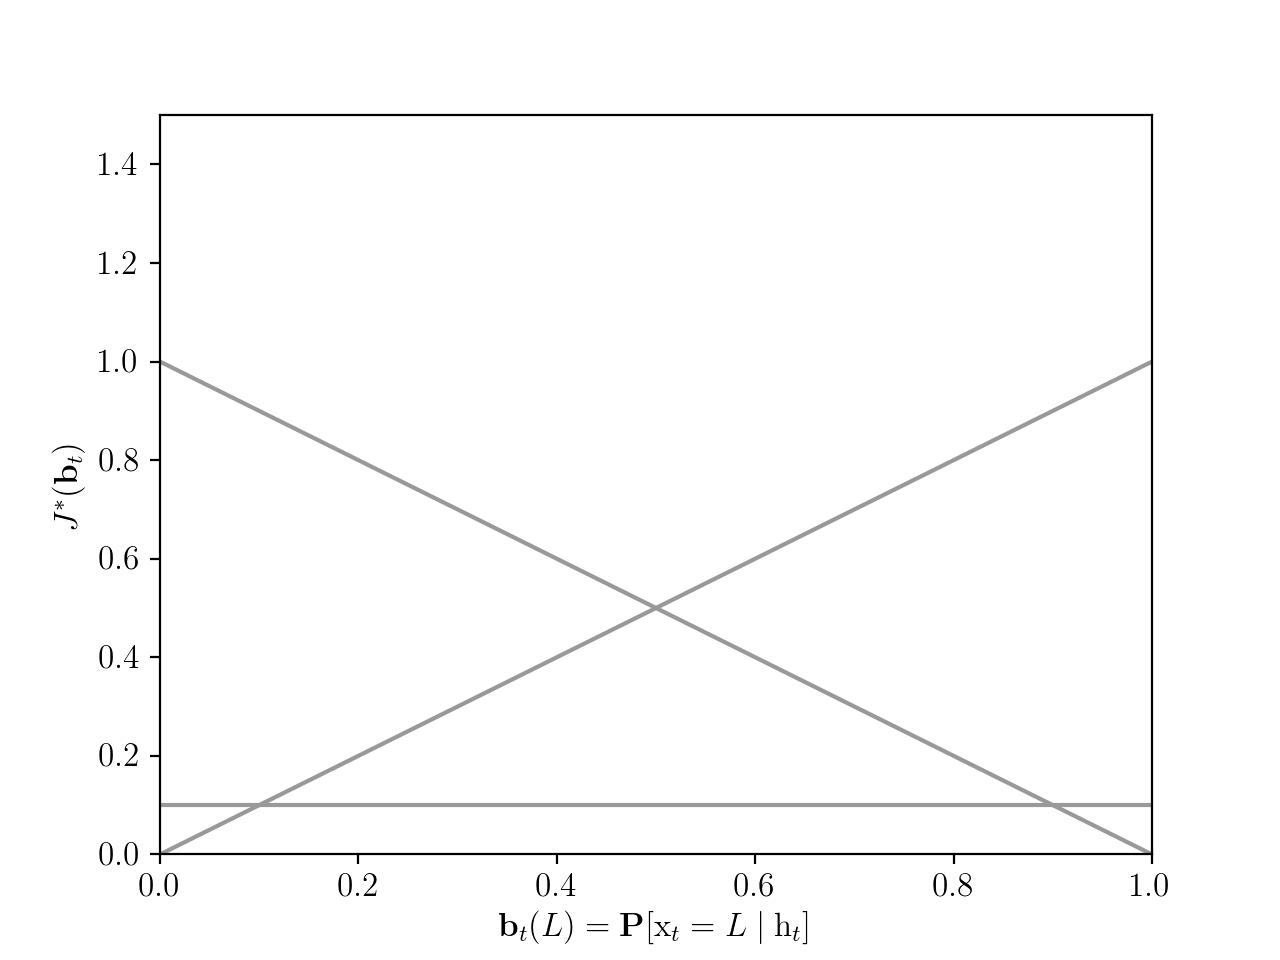

[[ 1.075    0.075    0.175    0.11125  0.27625]
 [ 0.075    1.075    0.175    0.27625  0.11125]]


<IPython.core.display.Javascript object>


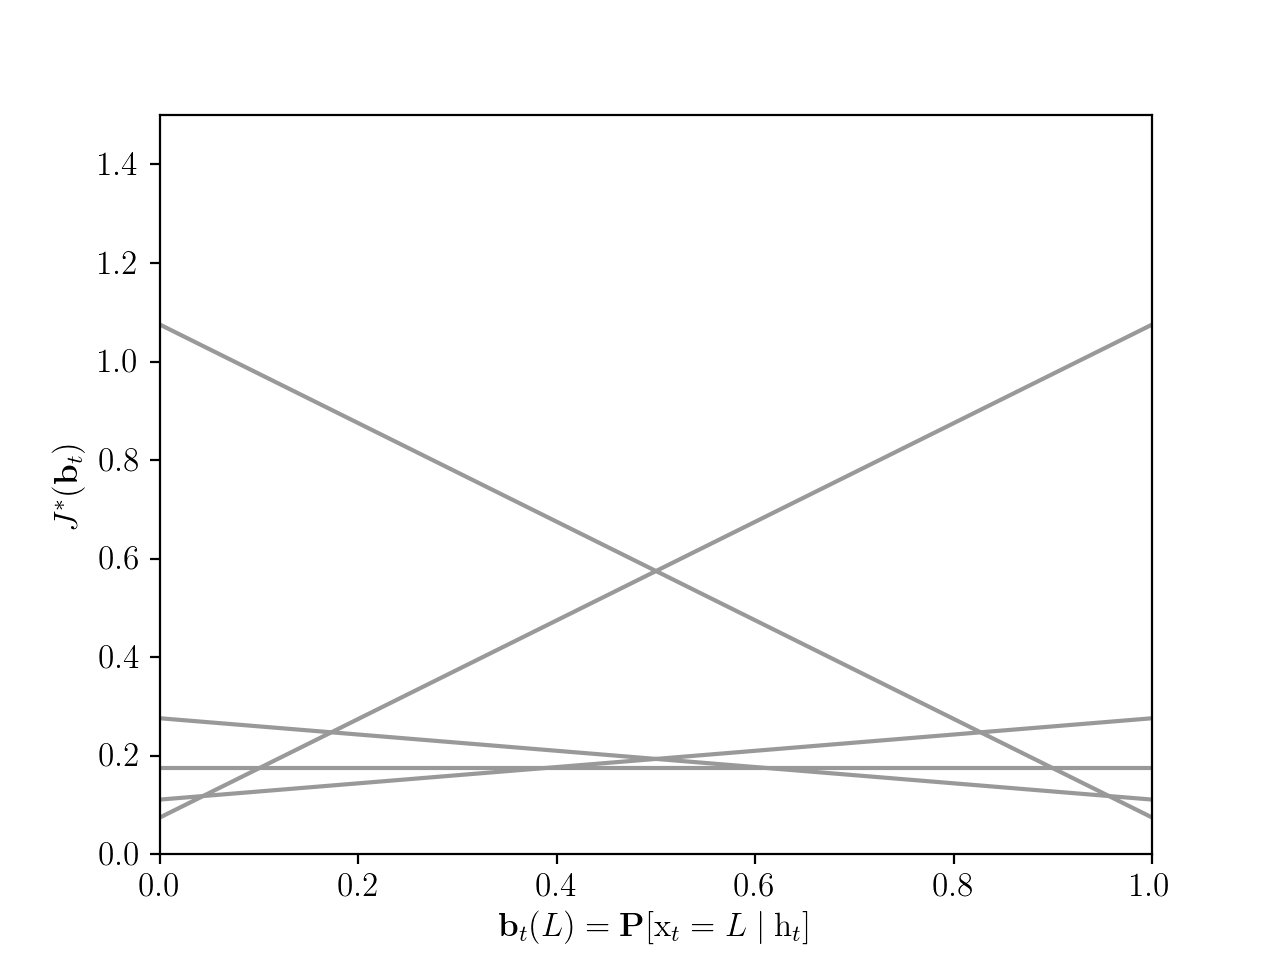

In [4]:
print(G1)
fig = plt.figure()

nv = G1.shape[1]
for v in range(nv):
    plt.plot(G1[:, v], color='0.60')

plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel(r'$J^*(\mathbf{b}_t)')
plt.axis([0, 1, 0, 1.5])
plt.show()
plt.savefig('tiger-iter-1.pdf')

print(G2)
fig = plt.figure()

nv = G2.shape[1]
for v in range(nv):
    plt.plot(G2[:, v], color='0.60')

plt.axis([0, 1, 0, 1.5])
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel(r'$J^*(\mathbf{b}_t)')
plt.show()
plt.savefig('tiger-iter-2.pdf')

<IPython.core.display.Javascript object>


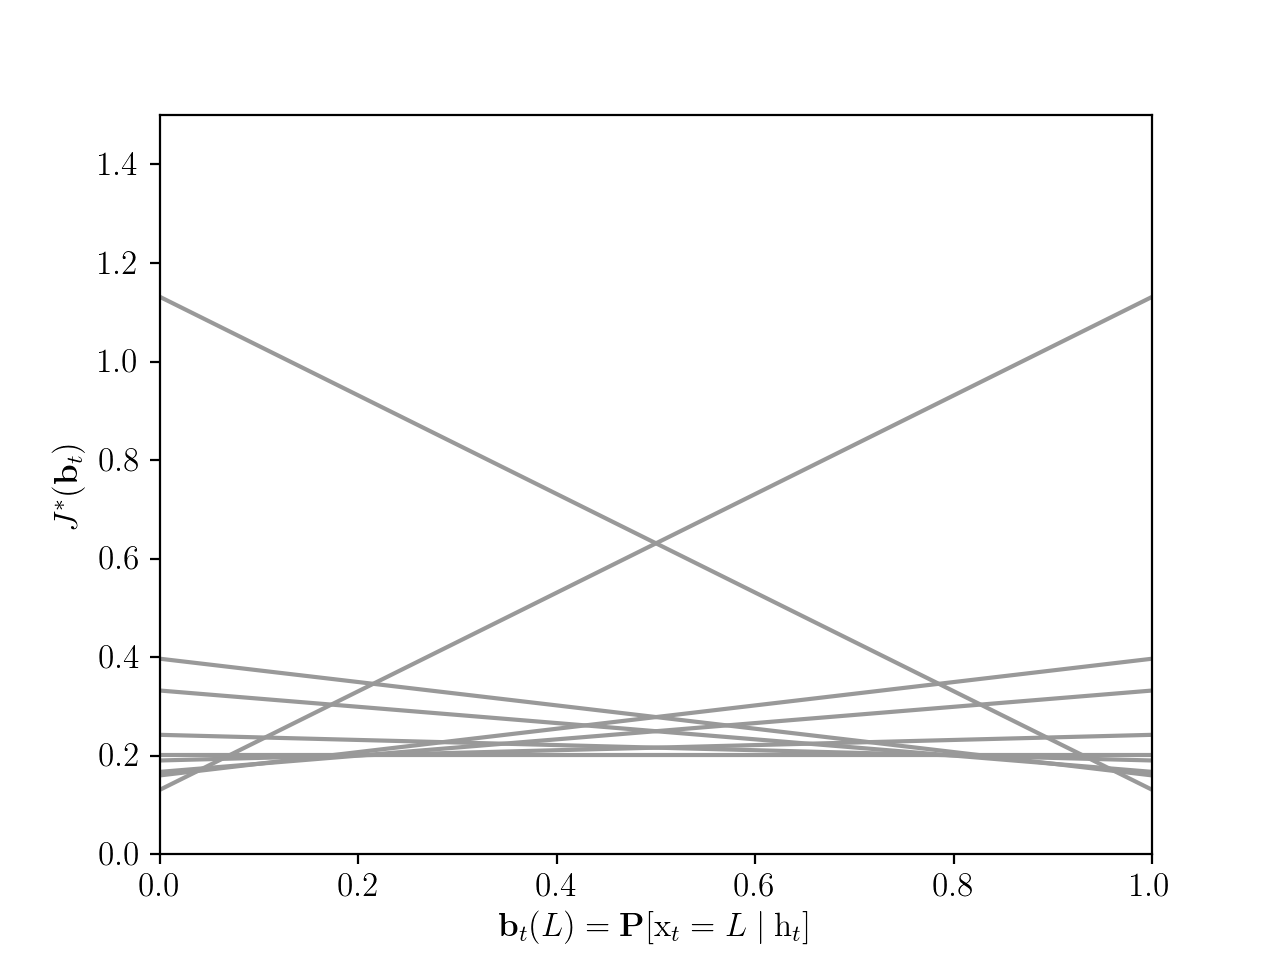

In [5]:
fig = plt.figure()

nv = G3.shape[1]

for v in range(nv):
    plt.plot(G3[:, v], color='0.60')

plt.axis([0, 1, 0, 1.5])
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel(r'$J^*(\mathbf{b}_t)')
plt.show()
plt.savefig('tiger-iter-3.pdf')

In [6]:
niter = 10
#niter = 20
T = list(range(1, niter + 1))

ttot = np.zeros(len(T))
nvec = np.zeros(len(T))

for k in log_progress(range(len(T)), every=1):
    n_iter = T[k]
    aux = time.time()
    g, a, i = sol.value_iteration(M, max_iter=n_iter)
    ttot[k] = time.time() - aux
    nvec[k] = reduce(lambda x, y: x + y, map(lambda x : x.size, g))

<IPython.core.display.Javascript object>


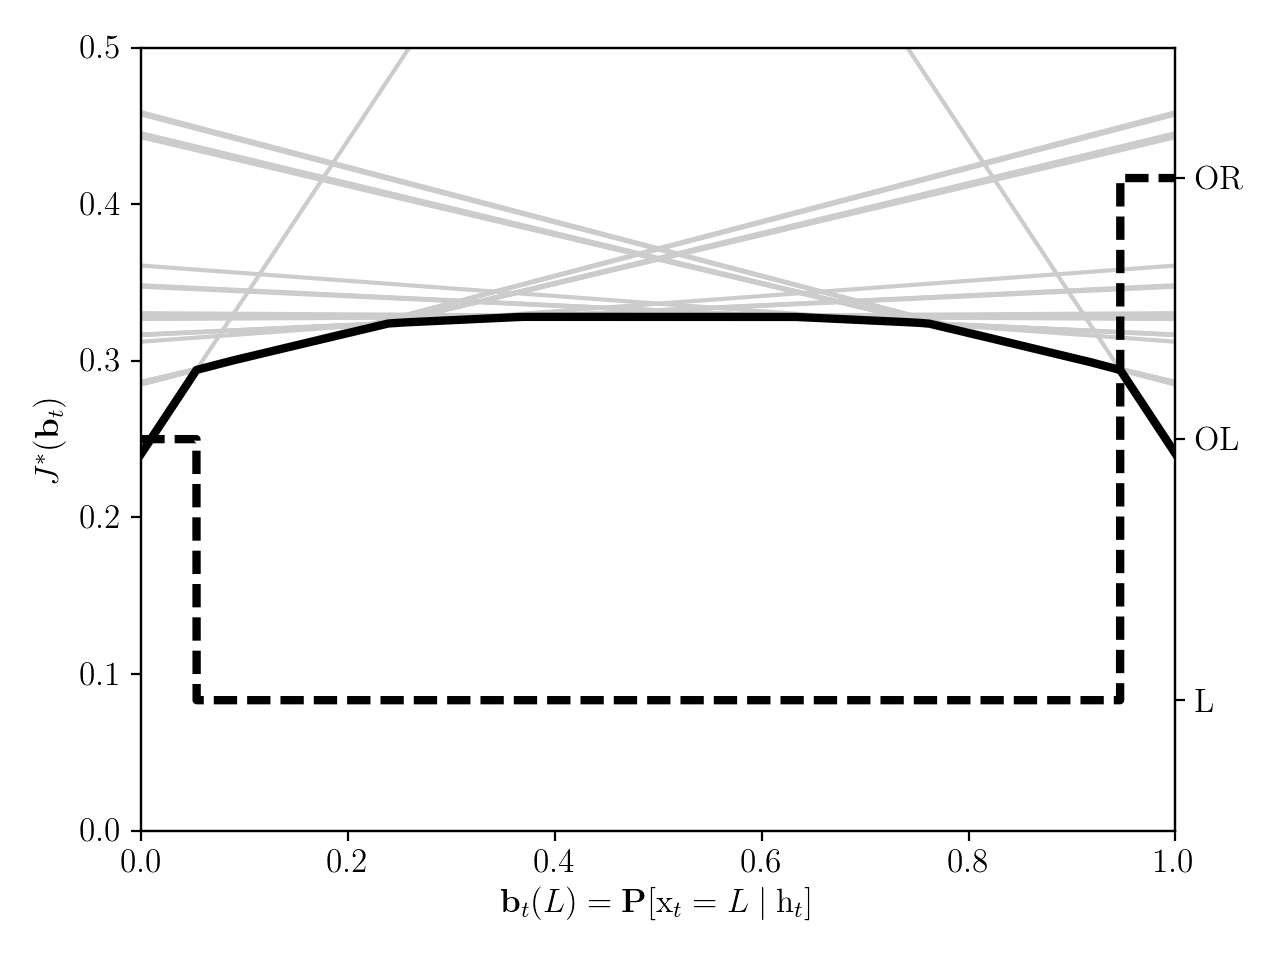

In [7]:
fig, ax1 = plt.subplots()

p = []
y = []
y_act = []

for i in range(10000):
    p = p + [i * 1/9999]
    b = np.array([p[i], 1 - p[i]])
    y += [b.dot(g).min()]
    
    aux = a[b.dot(g).argmin()]
    y_act += [M.get_action_index(aux)]
             
nv = g.shape[1]
for v in range(nv):
    ax1.plot(g[:, v], color='0.80')
            
plot1 = ax1.plot(p, y, 'k', linewidth=3, label='J^*')
ax1.set_xlim(0, 1)
ax1.set_xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
ax1.set_ylabel(r'$J^*(\mathbf{b}_t)')
ax1.set_ylim(0.0, 0.5)

ax2 = ax1.twinx()
plot2 = ax2.plot(p, y_act, 'k--', linewidth=3, label='Action')
ax2.set_xlim(0, 1)
ax2.set_ylim(-.5, 2.5)
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['L', 'OL', 'OR'])

plots = plot1 + plot2
labels = [p.get_label() for p in plots]

fig.tight_layout()
plt.show()
plt.savefig('tiger-iter-20.pdf')

<IPython.core.display.Javascript object>


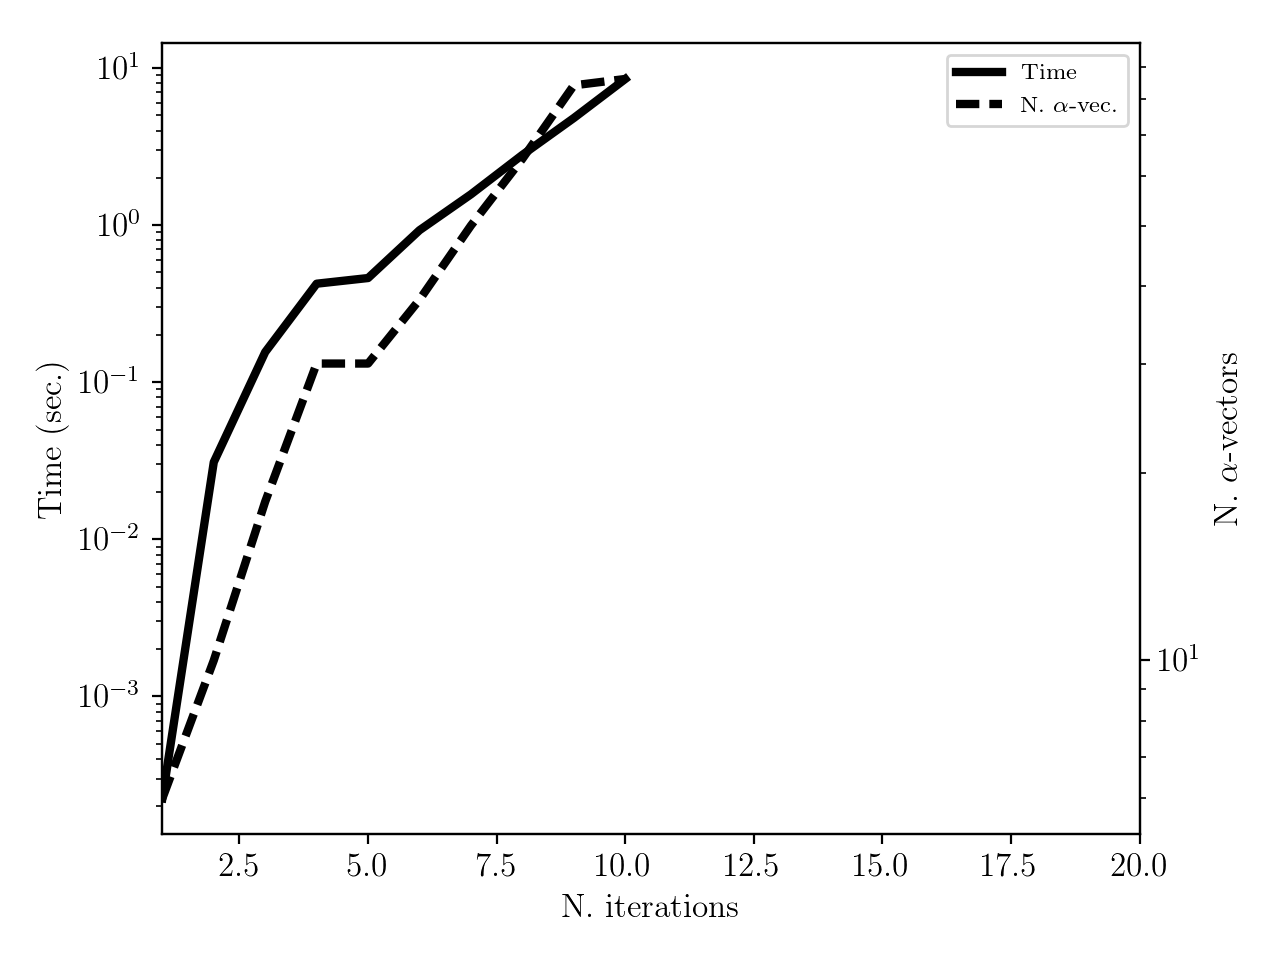

In [8]:
fig, ax1 = plt.subplots()

plot1 = ax1.semilogy(T, ttot, 'k-', linewidth=3, label='Time')
ax1.set_xlabel('N. iterations')
ax1.set_ylabel('Time (sec.)')
ax1.set_xlim(1,20)

ax2 = ax1.twinx()
plot2 = ax2.semilogy(T, nvec, 'k--', linewidth=3, label=r'N. $\alpha$-vec.')
ax2.set_ylabel(r'N. $\alpha$-vectors')
ax2.set_xlim(1,20)

plots = plot1 + plot2
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc='best', fontsize='x-small')

fig.tight_layout()
plt.show()
plt.savefig('tiger-time-vectors.pdf')

In [9]:
dtime = np.diff(ttot)
for i in range(len(T) - 1):
    t = str(T[i] + 1)
    print('N. vectors in iteration', t + ':', nvec[i])
    print('Time in iteration', t + ':', end=' ')
    if i == 0:
        print(ttot[i])
    else:
        print(dtime[i - 1])

N. vectors in iteration 2: 6.0
Time in iteration 2: 0.000224113464355
N. vectors in iteration 3: 10.0
Time in iteration 3: 0.0307607650757
N. vectors in iteration 4: 18.0
Time in iteration 4: 0.124592065811
N. vectors in iteration 5: 30.0
Time in iteration 5: 0.268339157104
N. vectors in iteration 6: 30.0
Time in iteration 6: 0.0367329120636
N. vectors in iteration 7: 38.0
Time in iteration 7: 0.467863082886
N. vectors in iteration 8: 50.0
Time in iteration 8: 0.642773866653
N. vectors in iteration 9: 64.0
Time in iteration 9: 1.22992300987
N. vectors in iteration 10: 84.0
Time in iteration 10: 2.00761008263


'listen' -> {0, 0}
'open-right' -> {0, 0}

'listen' -> {0, 0}
'open-left' -> {0, 0}
'open-right' -> {0, 0}
'listen' -> {2, 0}
'listen' -> {0, 1}

'listen' -> {0, 0}
'open-right' -> {0, 0}
'open-left' -> {0, 0}
'listen' -> {1, 0}
'listen' -> {3, 0}
'listen' -> {0, 2}
'listen' -> {1, 3}
'listen' -> {3, 2}



<IPython.core.display.Javascript object>


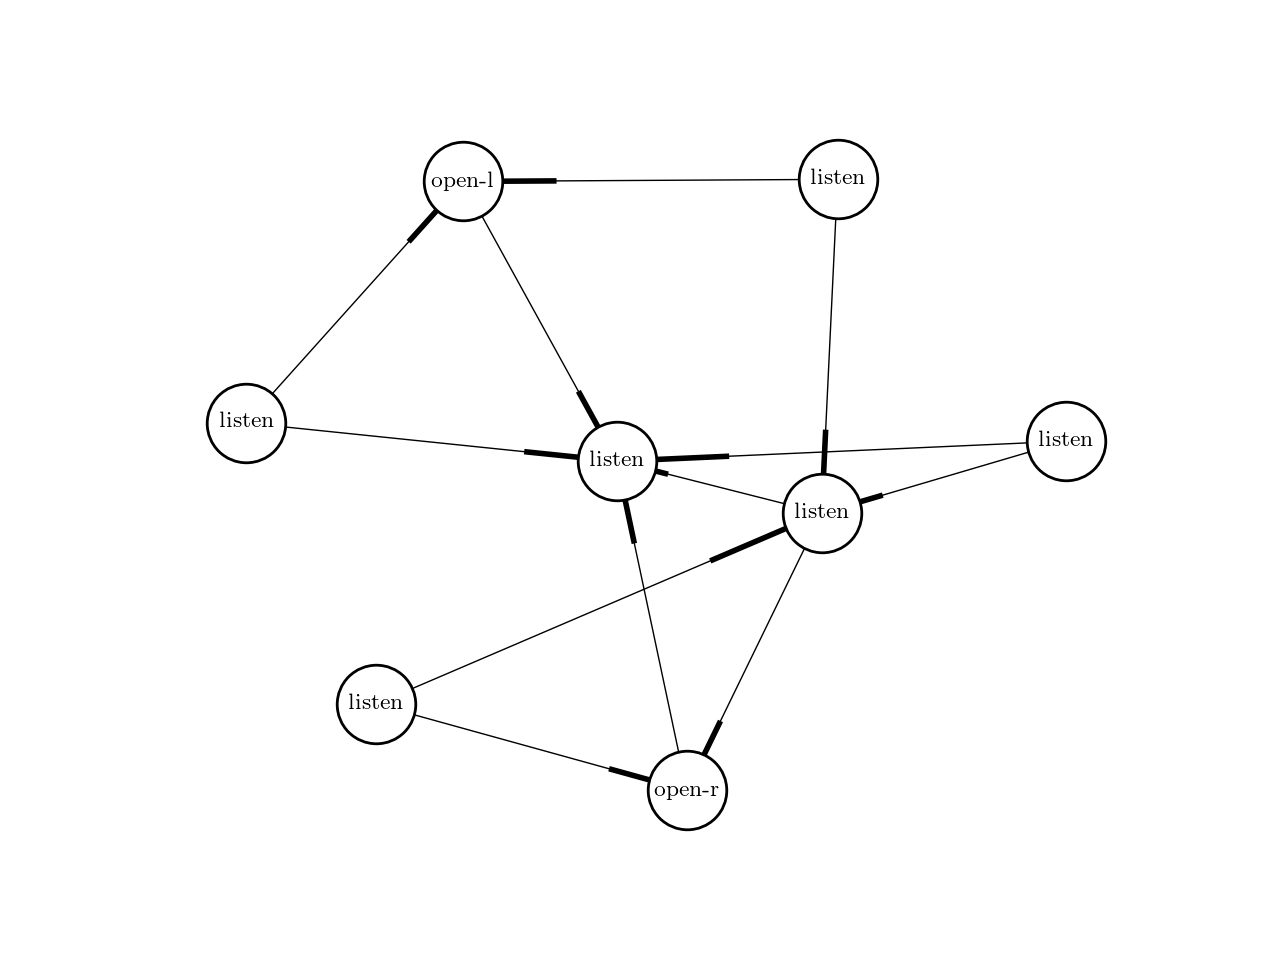

In [10]:
p1, _ = sol.policy_iteration(M, max_iter=1)
p2, _ = sol.policy_iteration(M, max_iter=2)
p3, _ = sol.policy_iteration(M, max_iter=3)

print(p1)
print(p2)
print(p3)

sol.draw(p3, 'test')
plt.savefig('tiger-pi-iter3.pdf')

### Web advertising

In [11]:
NRUNS = 10
NITERS = 5

M = env.parse('domains/mcc-example1.POMDP')

tvi = np.zeros((NRUNS, NITERS))
vvi = np.zeros(NITERS)
tpi = np.zeros((NRUNS, NITERS))
vpi = np.zeros(NITERS)

for iter in log_progress(range(1, NITERS + 1), every=1):
    for i in log_progress(range(NRUNS), every=1):
        t = time.time()
        q, _, _ = sol.value_iteration(M, max_iter=iter)
        tvi[i, iter - 1] = time.time() - t

        t = time.time()
        p, _ = sol.policy_iteration(M, max_iter=iter - 1)
        tpi[i, iter - 1] = time.time() - t
        
    vvi[iter - 1] = q.shape[1]
    vpi[iter - 1] = p.n_states()

    if iter == 3:
        pout = p
        qout = q
        
    beep()  
    
beep()

%store NRUNS
%store NITERS
%store M
%store tvi
%store tpi
%store pout
%store qout

Preamble: processed successfully.
Start: processed successfully.
Stochastic matrix T: processed successfully.
Stochastic matrix O: processed successfully.
Cost matrix: processed successfully.
File domains/mcc-example1.POMDP processed successfully.


Stored 'NRUNS' (int)
Stored 'NITERS' (int)
Stored 'M' (POMDP)
Stored 'tvi' (ndarray)
Stored 'tpi' (ndarray)
Stored 'pout' (Controller)
Stored 'qout' (ndarray)


'A2' -> {0, 0, 0}
'A1' -> {0, 0, 0}
'AN' -> {1, 1, 0}
'AN' -> {1, 0, 0}
'A1' -> {1, 1, 0}
'A1' -> {1, 0, 0}
'A2' -> {1, 0, 0}



<IPython.core.display.Javascript object>


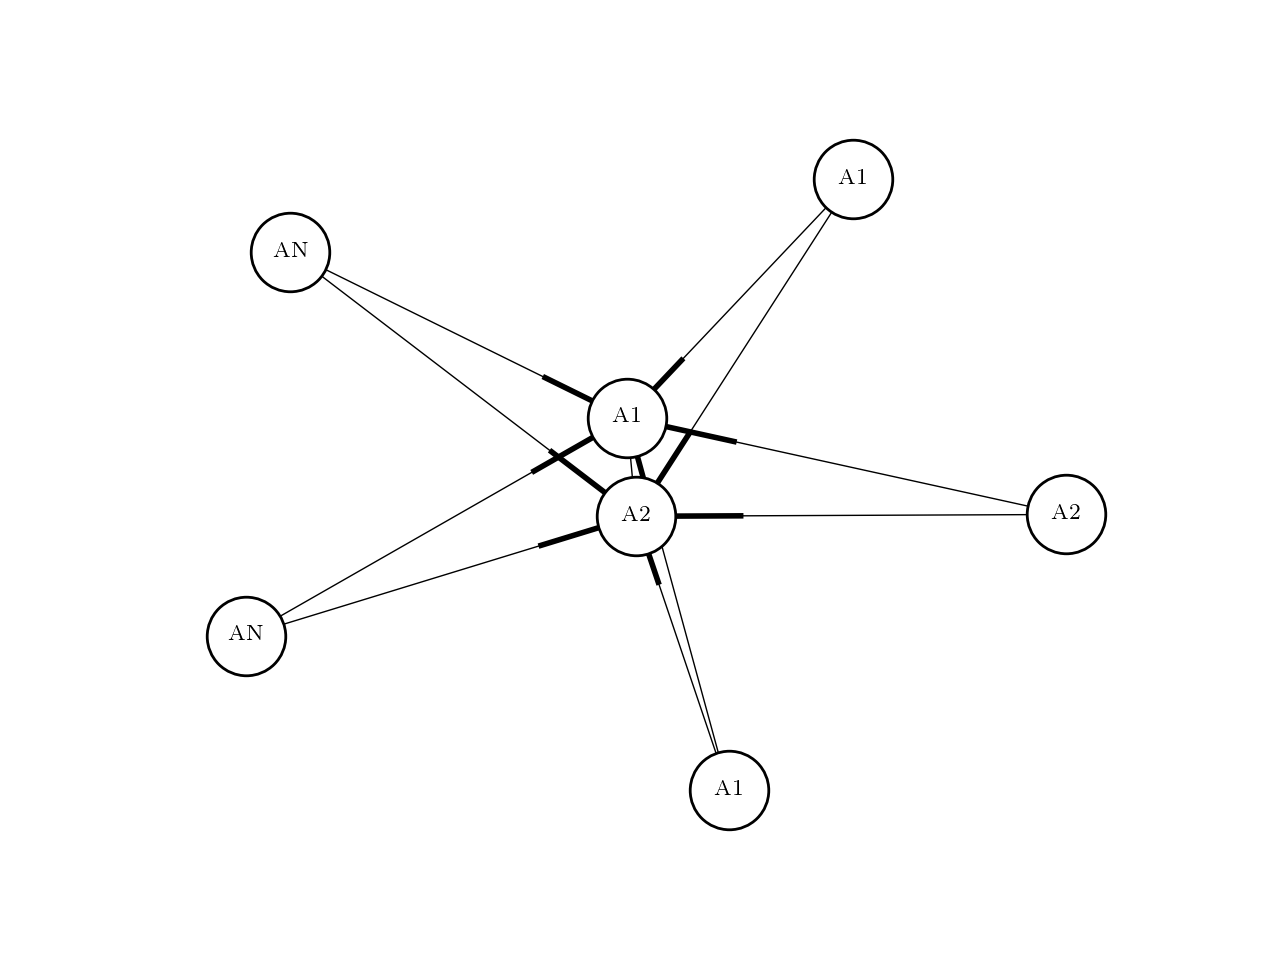

Set i_curr = 5
Stored 'i_curr' (int)


In [12]:
print(pout)
sol.draw(pout)

i_curr = iter
print('Set i_curr =', i_curr)
%store i_curr

In [13]:
# Restores all saved variables (NRUNS, NITERS, M, tvi and tpi)
%store -r 
opt = input('--> Now running ' + str(i_curr + 1) + ' iterations. Continue [y/N]? ')

if opt == 'y':
    aux_vi = np.zeros((NRUNS, 1))
    aux_pi = np.zeros((NRUNS, 1))

    for i in log_progress(range(NRUNS), every=1):
        t = time.time()
        q, _, _ = sol.value_iteration(M, max_iter=i_curr + 1)
        aux_vi[i] = time.time() - t

        t = time.time()
        p, _ = sol.policy_iteration(M, max_iter=i_curr)
        aux_pi[i] = time.time() - t
        
    tvi = np.concatenate((tvi, aux_vi), axis=1)
    tpi = np.concatenate((tpi, aux_pi), axis=1)
    
    vvi = np.append(vvi, q.shape[1])
    vpi = np.append(vpi, p.n_states())

    i_curr += 1
    
    beep(); beep()

%store i_curr
%store tvi
%store tpi

--> Now running 6 iterations. Continue [y/N]? n
Stored 'i_curr' (int)
Stored 'tvi' (ndarray)
Stored 'tpi' (ndarray)


In [14]:
print('Doing 5...')
p5, _ = sol.policy_iteration(M, max_iter=5)
print('Doing 7...')
p7, _ = sol.policy_iteration(M, max_iter=7)
print('Doing 10...')
p10, _ = sol.policy_iteration(M, max_iter=10)
print('Done.')

%store p5
%store p7
%store p10

Stored 'p5' (Controller)
Stored 'p7' (Controller)
Stored 'p10' (Controller)


<IPython.core.display.Javascript object>


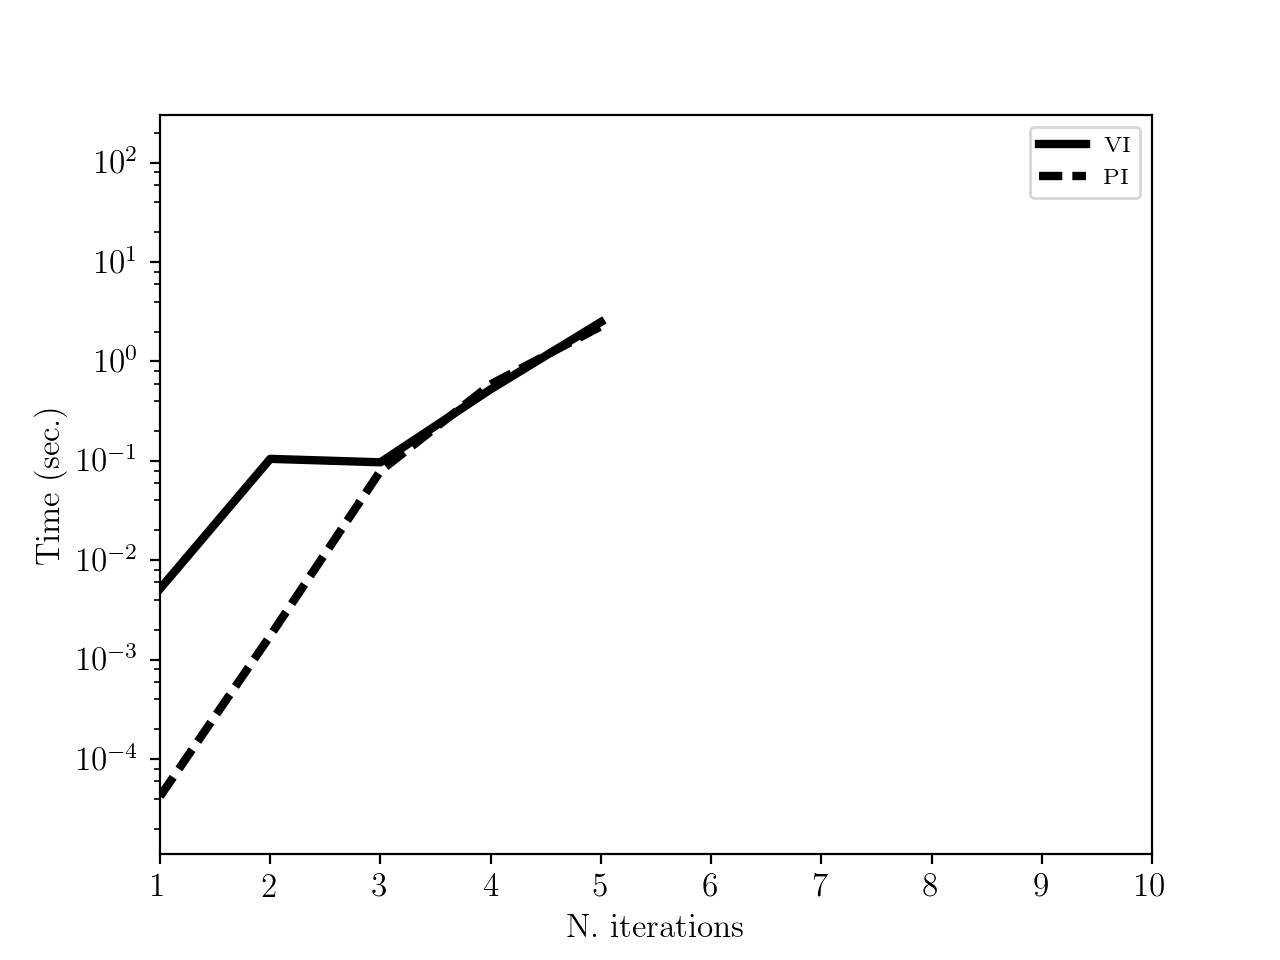

<IPython.core.display.Javascript object>


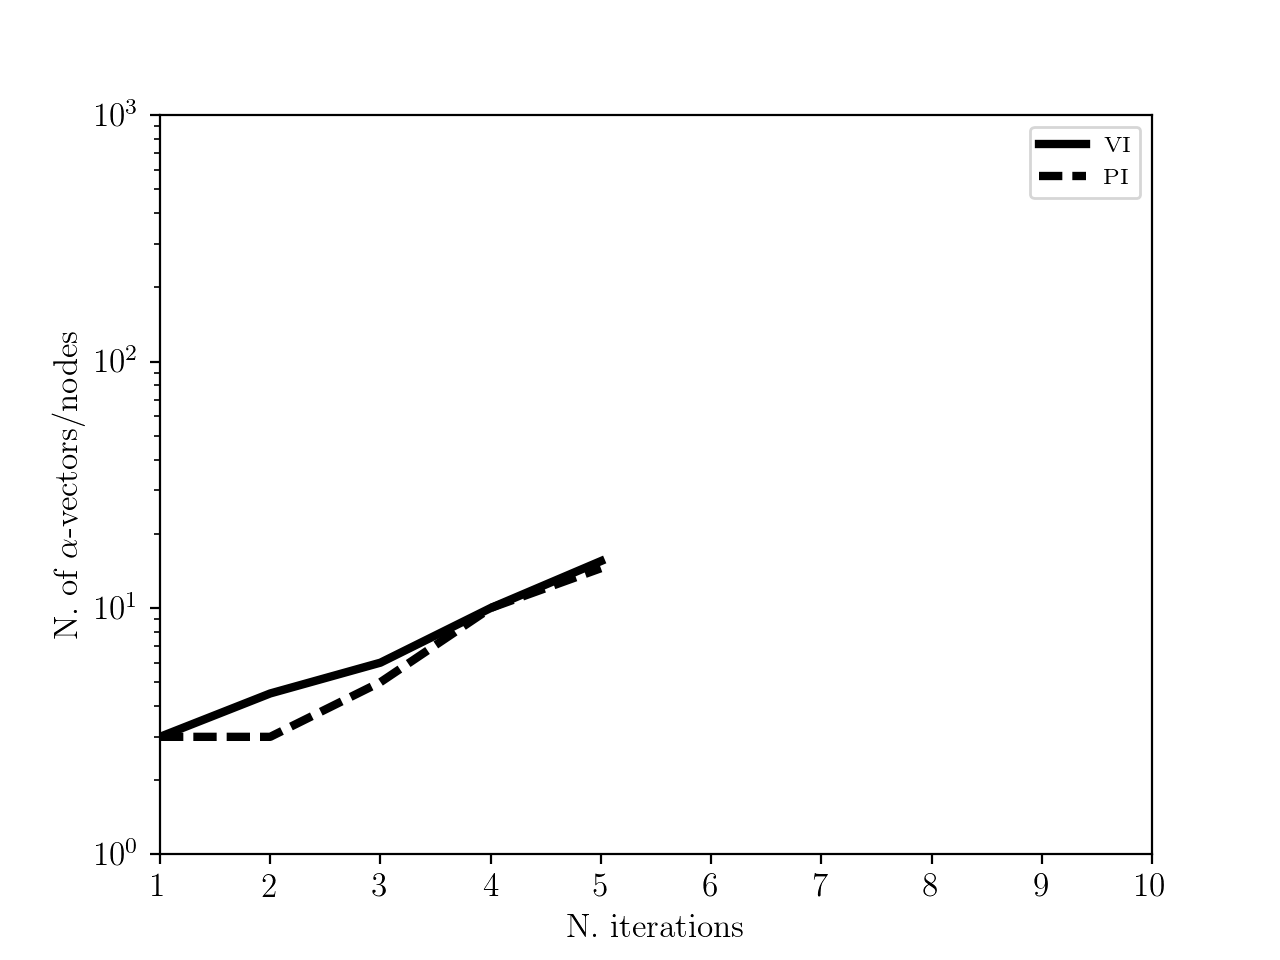

In [19]:
aa = np.copy(tpi)
bb = np.copy(tvi)
aa[:,0] = np.copy(tvi[:,0])
bb[:,0] = np.copy(tpi[:,0])

fig = plt.figure()
plt.semilogy(range(1, i_curr + 1), np.mean(bb, axis=0), 'k-', linewidth=3, label='VI')
plt.semilogy(range(1, i_curr + 1), np.mean(aa, axis=0), 'k--', linewidth=3, label='PI')
plt.xlabel('N. iterations')
plt.ylabel('Time (sec.)')
plt.legend(loc='best', fontsize='x-small')
plt.axis([1, 10, 1.1e-5, 300])

plt.show()
plt.savefig('web-time.pdf')

aa = np.copy(vvi)
aa[1:] = (aa[1:] + vvi[:-1]) / 2
bb = np.copy(vpi)
bb[1:] = (bb[1:] + vpi[:-1]) / 2

fig = plt.figure()
plt.semilogy(range(1, i_curr + 1), aa, 'k-', linewidth=3, label='VI')
plt.semilogy(range(1, i_curr + 1), bb, 'k--', linewidth=3, label='PI')
plt.xlabel('N. iterations')
plt.ylabel(r'N. of $\alpha$-vectors/nodes')
plt.legend(loc='best', fontsize='x-small')
plt.axis([1, 10, 1, 1e3])

plt.show()
plt.savefig('web-vectors.pdf')

<IPython.core.display.Javascript object>


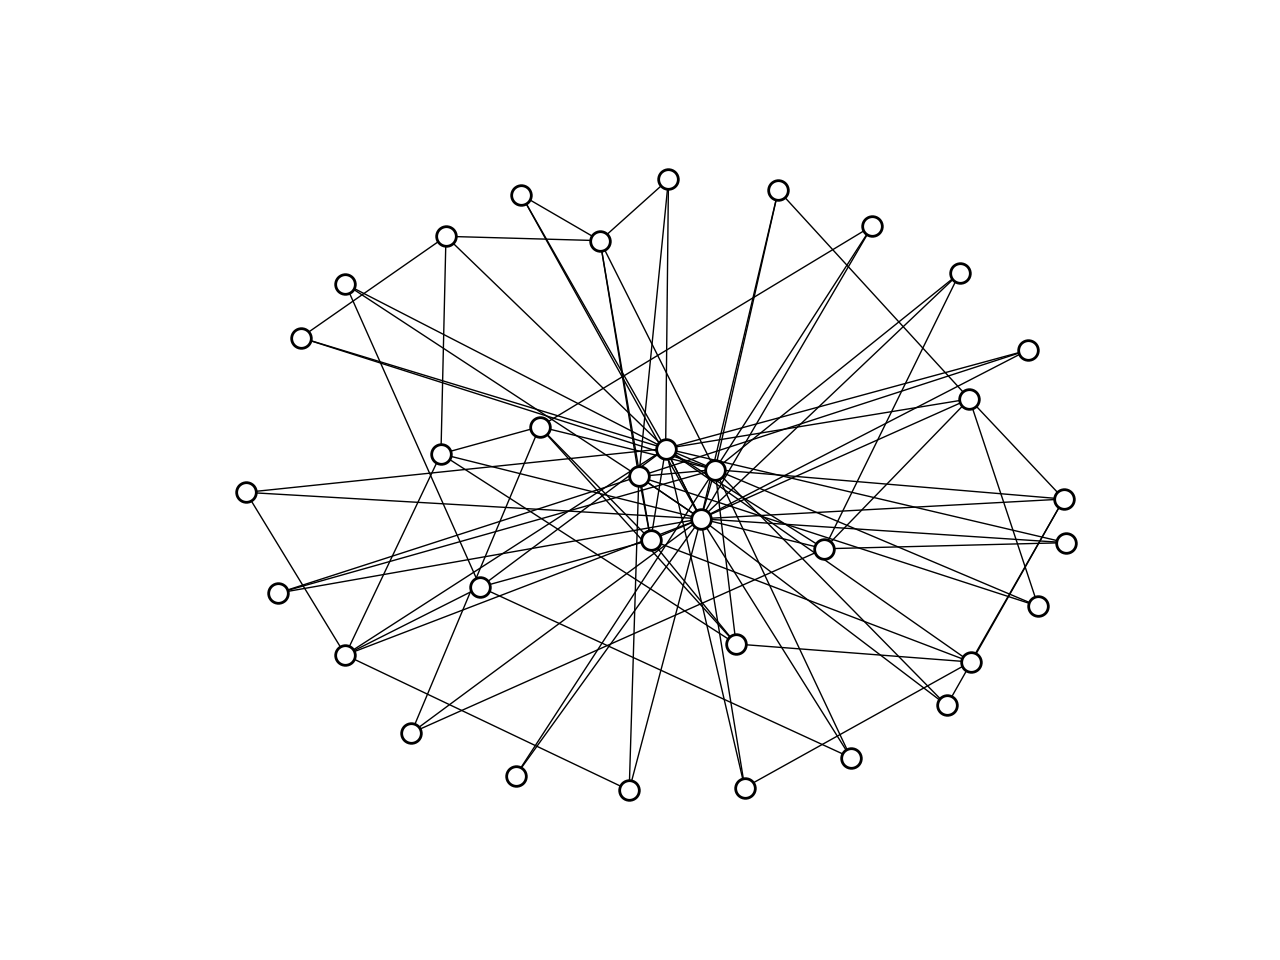

<IPython.core.display.Javascript object>


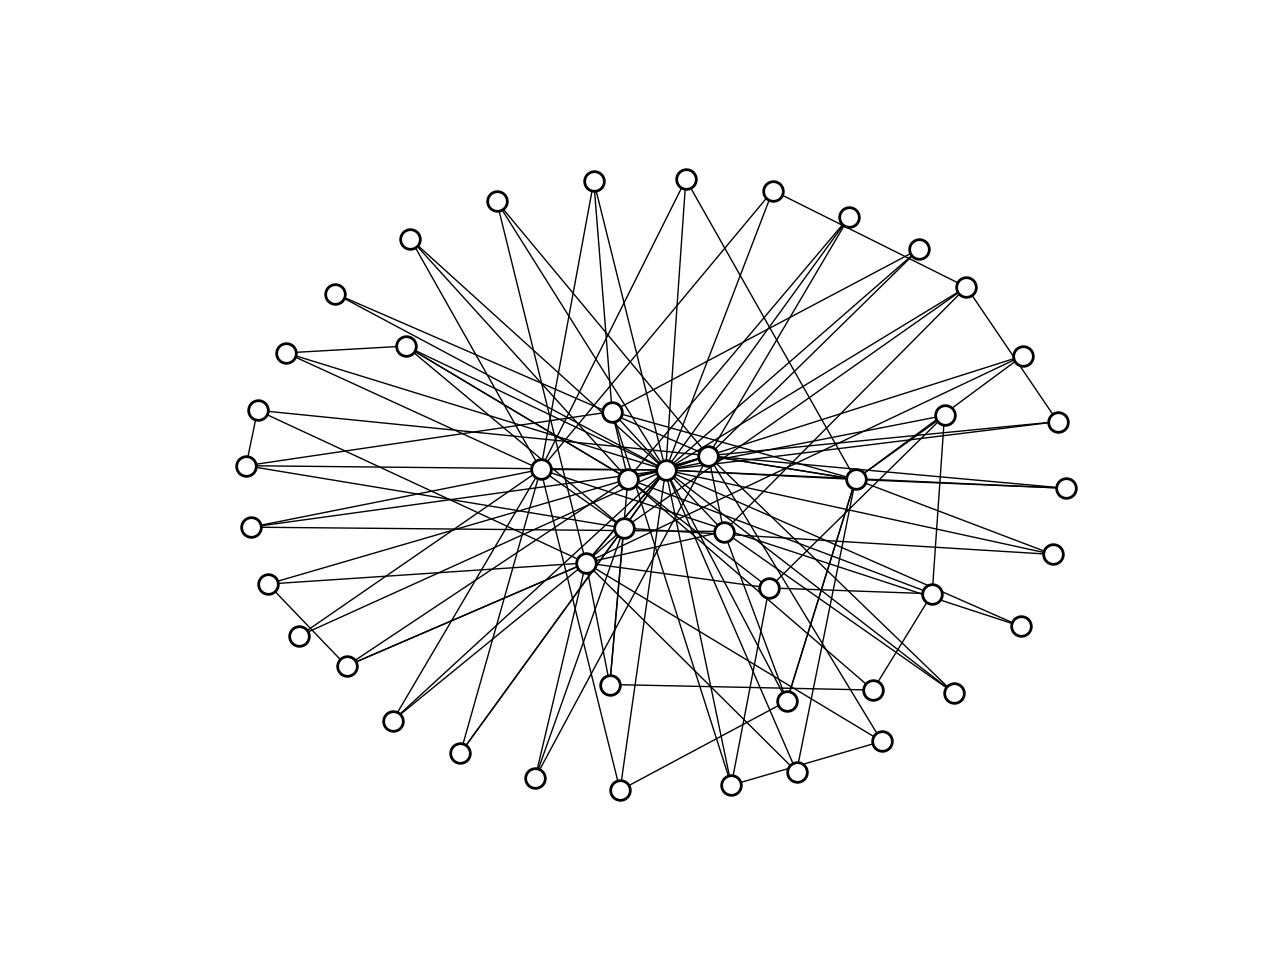

<IPython.core.display.Javascript object>


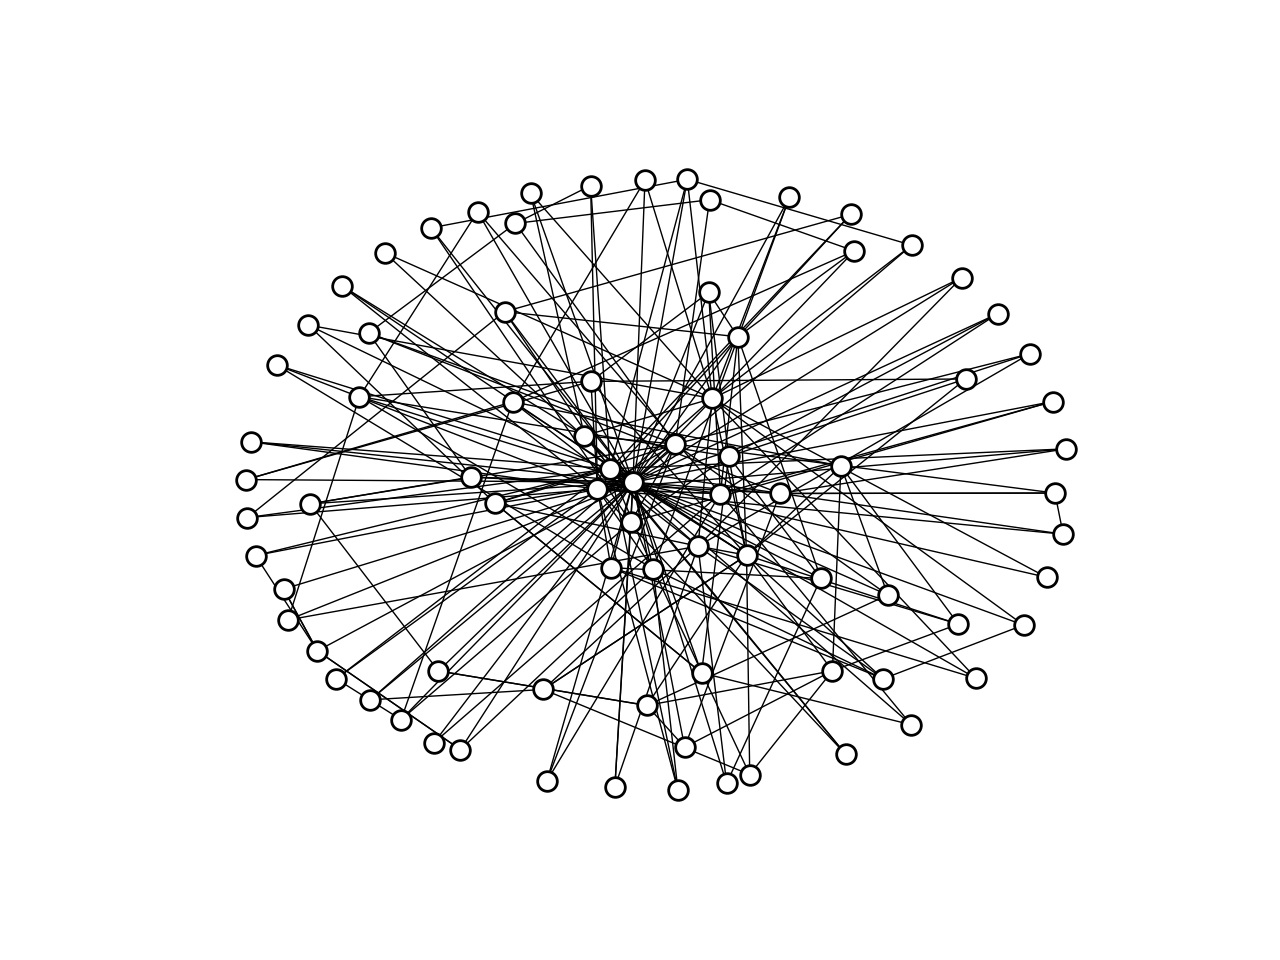

Nodes after 5 iterations: 34
Nodes after 7 iterations: 45
Nodes after 10 iterations: 81


In [20]:
sol.draw(p5, with_labels=False, node_size=50, arrows=False)
plt.savefig('web-pgraph-5.pdf')
sol.draw(p7, with_labels=False, node_size=50, arrows=False)
plt.savefig('web-pgraph-7.pdf')
sol.draw(p10, with_labels=False, node_size=50, arrows=False)
plt.savefig('web-pgraph-10.pdf')

print('Nodes after 5 iterations:', p5.n_states())
print('Nodes after 7 iterations:', p7.n_states())
print('Nodes after 10 iterations:', p10.n_states())

### Shuttle

In [35]:
M = env.parse('domains/shuttle.95.POMDP')
p3_shuttle, _ = sol.policy_iteration(M, max_iter=3)
%store p3_shuttle
beep(); beep()

Preamble: processed successfully.
Start: processed successfully.
Stochastic matrix T: processed successfully.
Stochastic matrix O: processed successfully.
Cost matrix: processed successfully.
File domains/shuttle.95.POMDP processed successfully.
Stored 'p3_shuttle' (Controller)


<IPython.core.display.Javascript object>


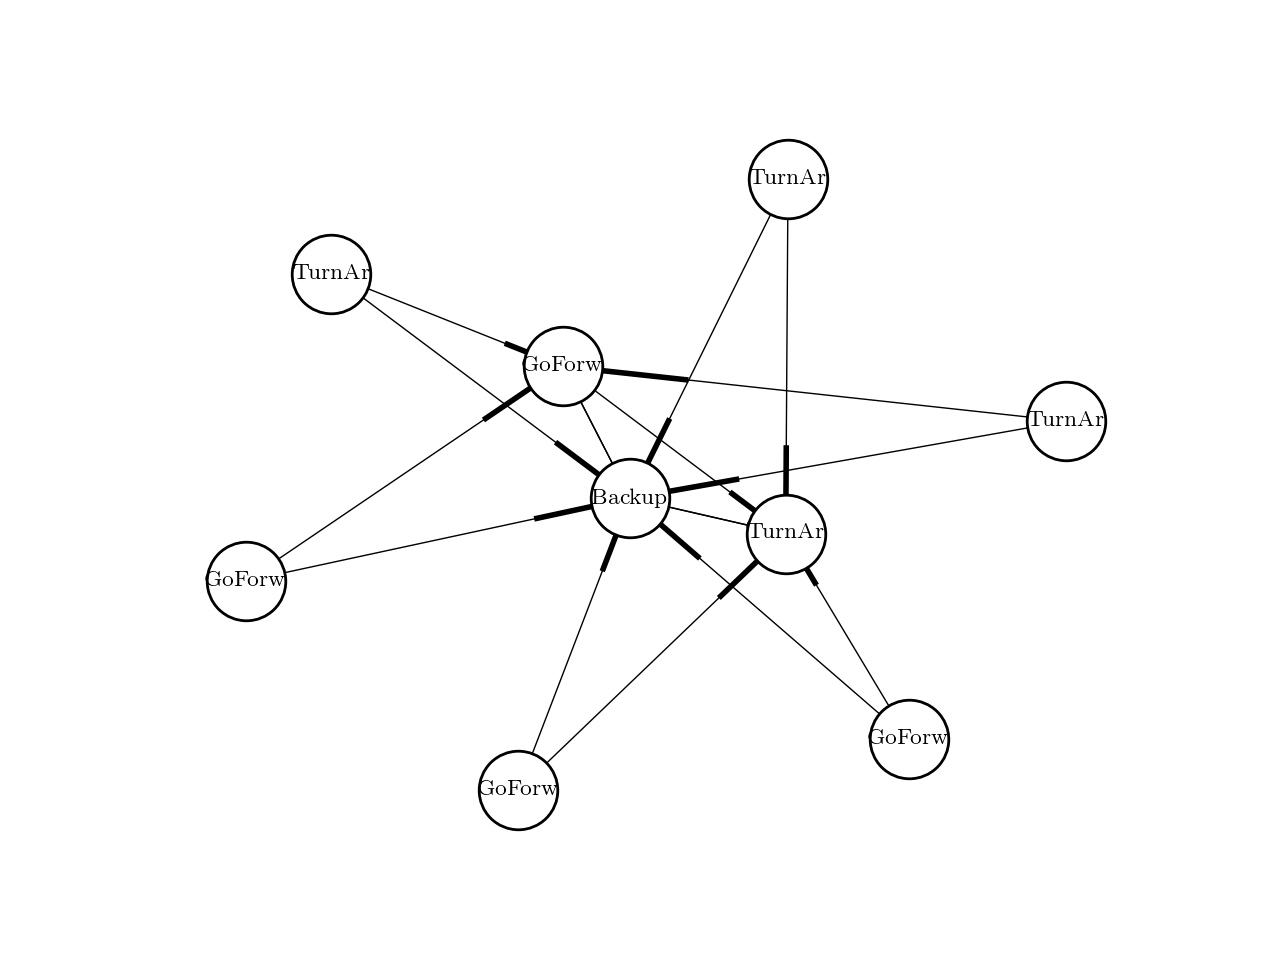

'Backup' -> {1, 0, 2, 0, 0}
'TurnAround' -> {1, 0, 0, 0, 0}
'GoForward' -> {1, 0, 0, 0, 0}
'TurnAround' -> {2, 0, 0, 0, 0}
'GoForward' -> {2, 0, 0, 0, 0}
'TurnAround' -> {2, 0, 0, 0, 0}
'TurnAround' -> {1, 0, 0, 0, 0}
'GoForward' -> {1, 0, 0, 0, 0}
'GoForward' -> {1, 0, 0, 0, 0}



In [36]:
sol.draw(p3_shuttle)
print(p3_shuttle)
plt.savefig('shuttle-pgraph-3.pdf')

### MDP Heuristics

In [38]:
M = env.parse('domains/tiger.aaai.POMDP')

g_opt, l_opt, i_opt = sol.value_iteration(M, max_iter=10)

p_MDP, _ = sol.policy_iteration(M, as_mdp=True)
q_MDP, _ = sol.value_iteration(M, as_mdp=True, cost=False)
q_FIB, _ = sol.fib(M)

i_MDP = np.isclose(q_MDP, q_MDP.min(axis=1, keepdims=True), rtol=1e-10, atol=1e-10)
i_FIB = np.isclose(q_FIB, q_FIB.min(axis=1, keepdims=True), rtol=1e-10, atol=1e-10)

t = time.time()
g_per, l_per, i_per = sol.perseus(M)
t = time.time() - t

print('Time (perseus):', t)
print('Iterations (perseus):', i_per)

t = time.time()
pol_pbpi, i_pbpi = sol.pbpi(M)
t = time.time() - t

g_pbpi = pol_pbpi.evaluate(M)
l_pbpi = pol_pbpi.labels()

print('Time (pbpi):', t)
print('Iterations (pbpi):', i_pbpi)
beep(); beep();

print('\nQMDP:')
print(q_MDP)
print('\nQFIB:')
print(q_FIB)

Preamble: processed successfully.
Start: processed successfully.
Stochastic matrix T: processed successfully.
Stochastic matrix O: processed successfully.
Cost matrix: processed successfully.
File domains/tiger.aaai.POMDP processed successfully.
FIB ended after 65 iterations
Sampling... Complete. Running...
Completed 25 iterations so far. Still running...
Completed 50 iterations so far. Still running...
Completed 75 iterations so far. Still running...
Complete after 79 iterations.
Time (perseus): 0.2401411533355713
Iterations (perseus): 79
Sampling... Complete. Running...
Complete after 4 iterations.
Time (pbpi): 0.12343406677246094
Iterations (pbpi): 4

QMDP:
[[ 0.1  1.   0. ]
 [ 0.1  0.   1. ]]

QFIB:
[[ 0.22857143  1.17142857  0.17142857]
 [ 0.22857143  0.17142857  1.17142857]]


#### MLS, AV, QMDP

<IPython.core.display.Javascript object>


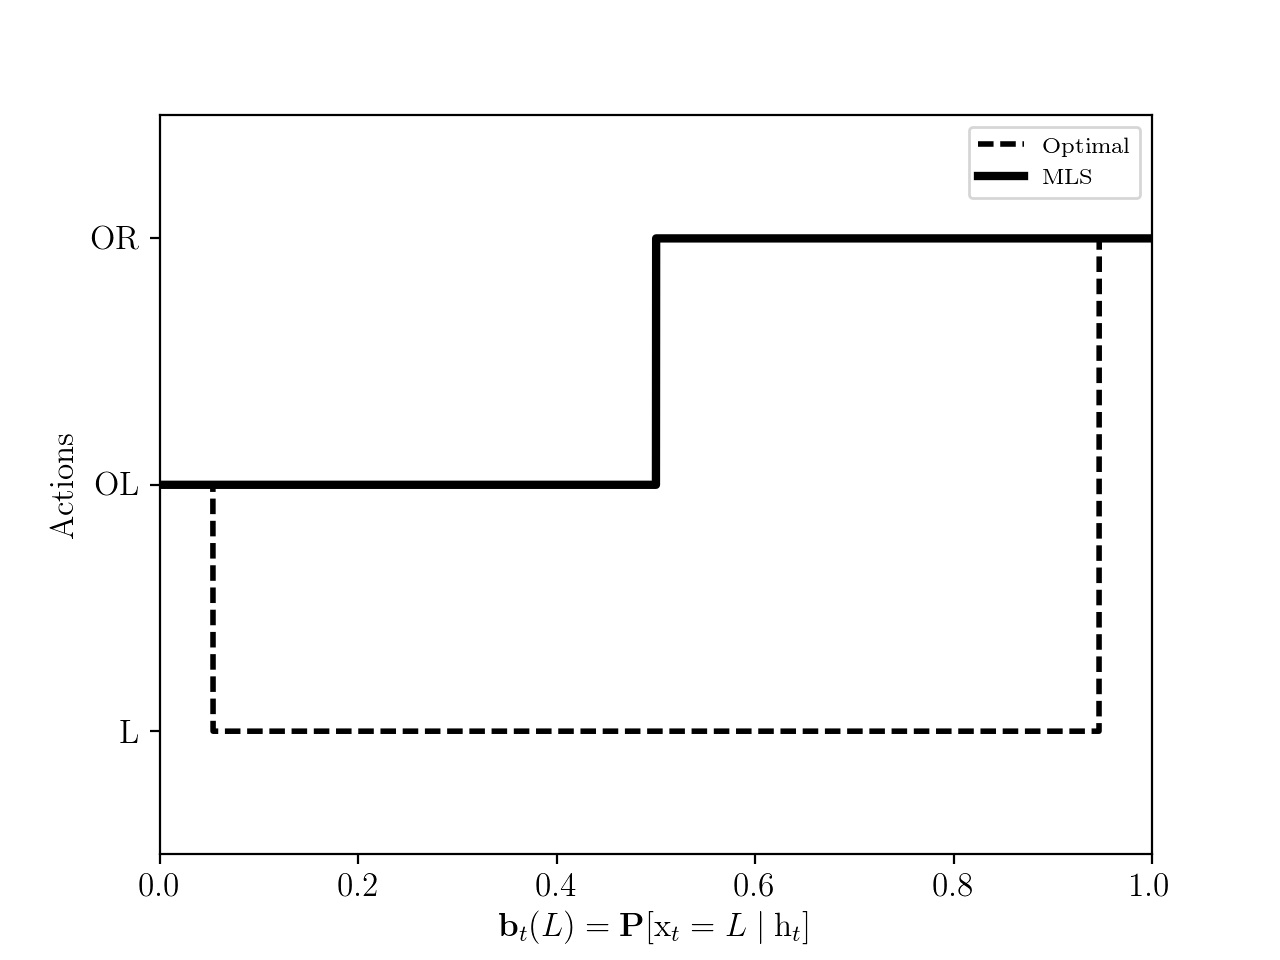

<IPython.core.display.Javascript object>


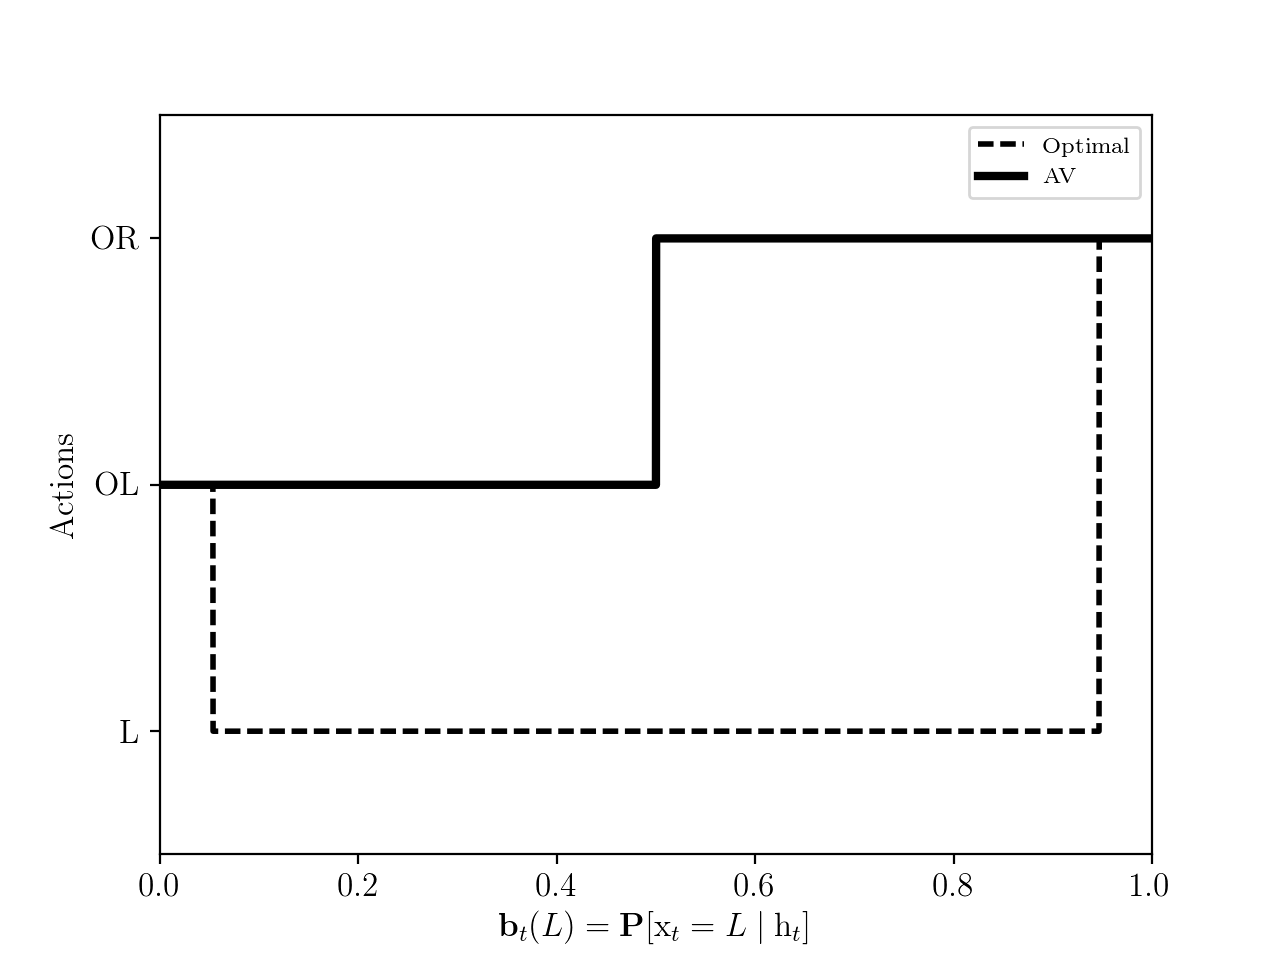

<IPython.core.display.Javascript object>


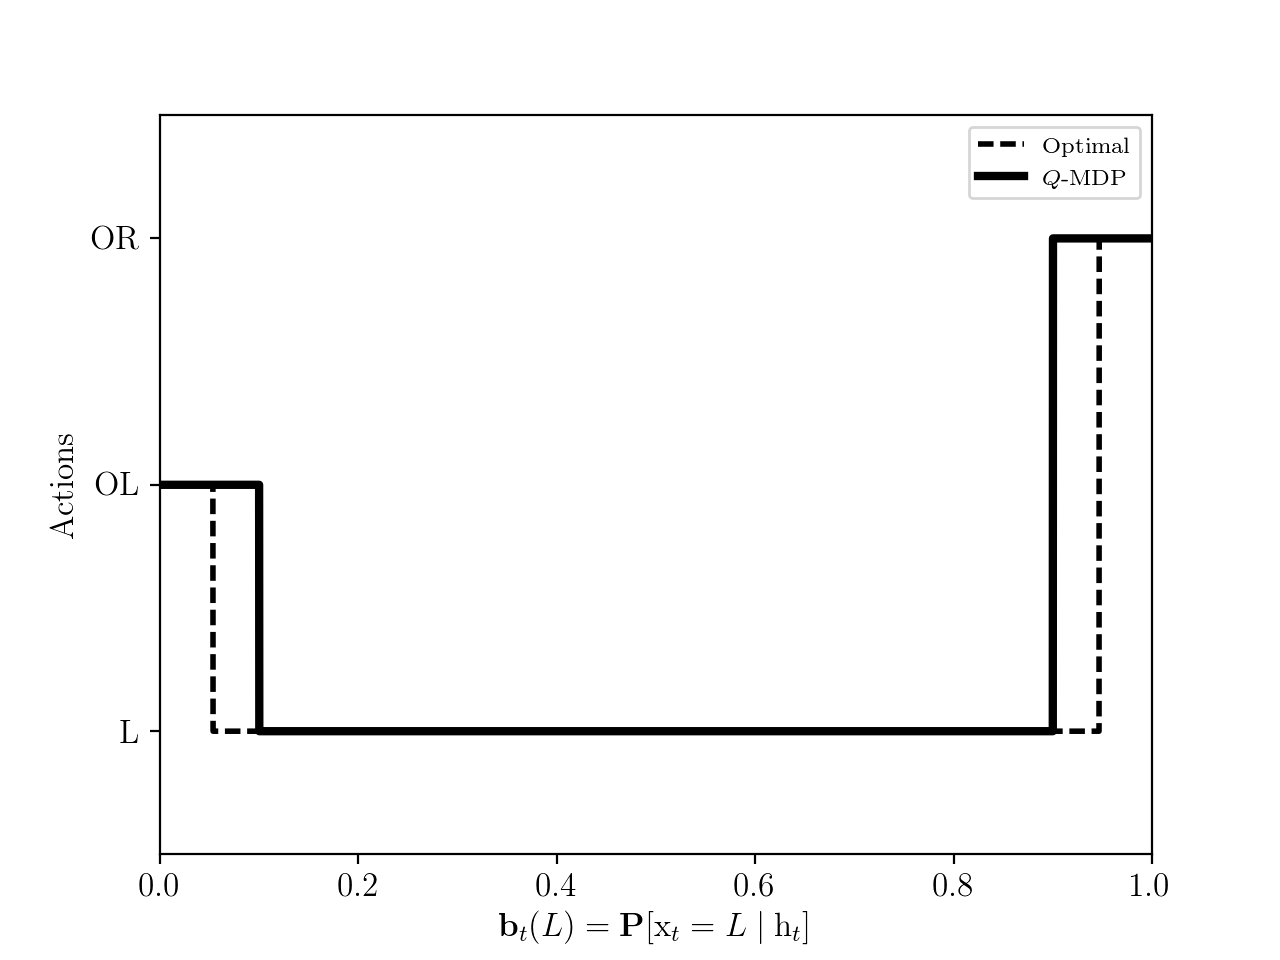

<IPython.core.display.Javascript object>


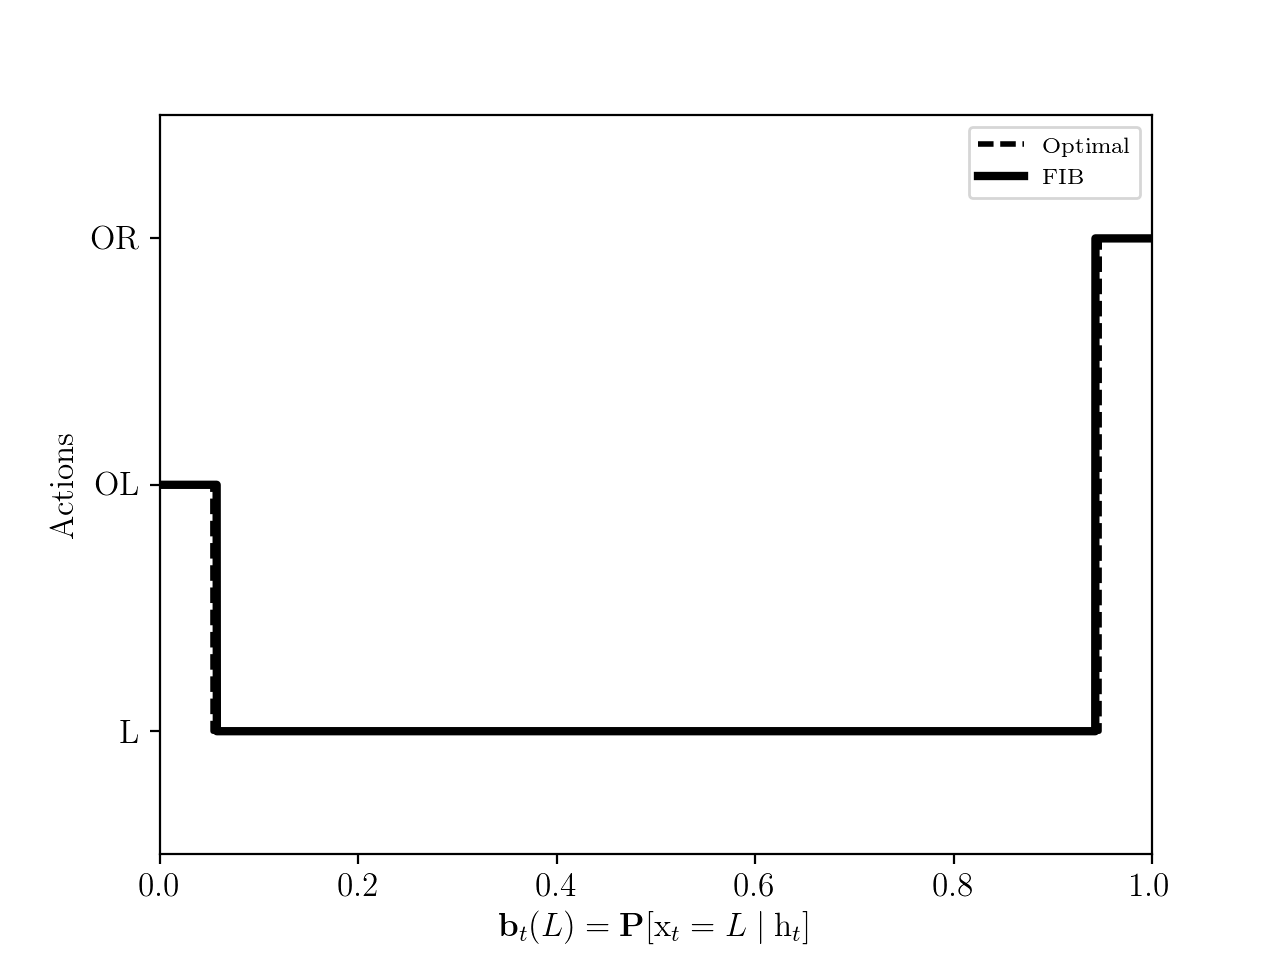

In [39]:
p     = []
y_opt = []
y_mls = []
y_av  = []
y_mdp = []
y_fib = []

for i in range(10000):
    p = p + [i * 1/9999]
    b = np.array([p[i], 1 - p[i]])

    aux = l_opt[b.dot(g_opt).argmin()]
    y_opt += [M.get_action_index(aux)]

    aux = p_MDP.get_action(int(b.argmax()))
    y_mls += [M.get_action_index(aux)]
    y_av  += [b.dot(i_MDP).argmax()]
    
    y_mdp += [b.dot(q_MDP).argmin()]
    y_fib += [b.dot(q_FIB).argmin()]

fig = plt.figure()
plt.plot(p, y_opt, 'k--', linewidth=2, label='Optimal')
plt.plot(p, y_mls, 'k', linewidth=3, label='MLS')
plt.axis([0, 1, -.5, 2.5])
plt.axis([0, 1, -.5, 2.5])
plt.yticks([0, 1, 2], ['L', 'OL', 'OR'])
plt.legend(loc='best', fontsize='x-small')
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel('Actions')

plt.show()
plt.savefig('tiger-mls.pdf')

fig = plt.figure()
plt.plot(p, y_opt, 'k--', linewidth=2, label='Optimal')
plt.plot(p, y_av, 'k', linewidth=3, label='AV')
plt.axis([0, 1, -.5, 2.5])
plt.yticks([0, 1, 2], ['L', 'OL', 'OR'])
plt.legend(loc='best', fontsize='x-small')
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel('Actions')

plt.show()
plt.savefig('tiger-av.pdf')

fig = plt.figure()
plt.plot(p, y_opt, 'k--', linewidth=2, label='Optimal')
plt.plot(p, y_mdp, 'k', linewidth=3, label='$Q$-MDP')
plt.axis([0, 1, -.5, 2.5])
plt.yticks([0, 1, 2], ['L', 'OL', 'OR'])
plt.legend(loc='best', fontsize='x-small')
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel('Actions')

plt.show()
plt.savefig('tiger-mdp.pdf')

plt.show()
plt.savefig('tiger-av.pdf')

fig = plt.figure()
plt.plot(p, y_opt, 'k--', linewidth=2, label='Optimal')
plt.plot(p, y_fib, 'k', linewidth=3, label='FIB')
plt.axis([0, 1, -.5, 2.5])
plt.yticks([0, 1, 2], ['L', 'OL', 'OR'])
plt.legend(loc='best', fontsize='x-small')
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel('Actions')

plt.show()
plt.savefig('tiger-fib.pdf')

<IPython.core.display.Javascript object>


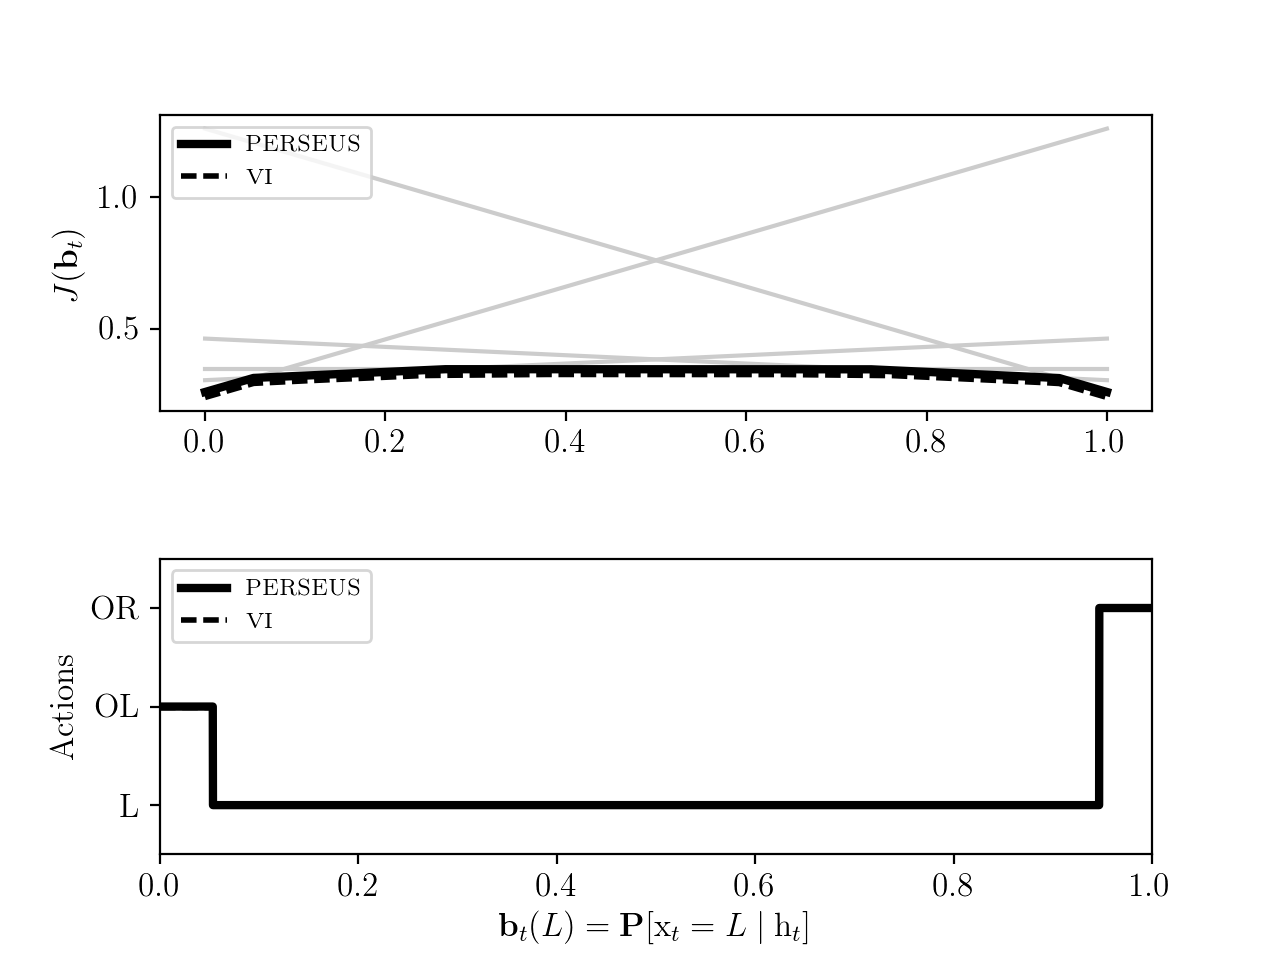

<IPython.core.display.Javascript object>


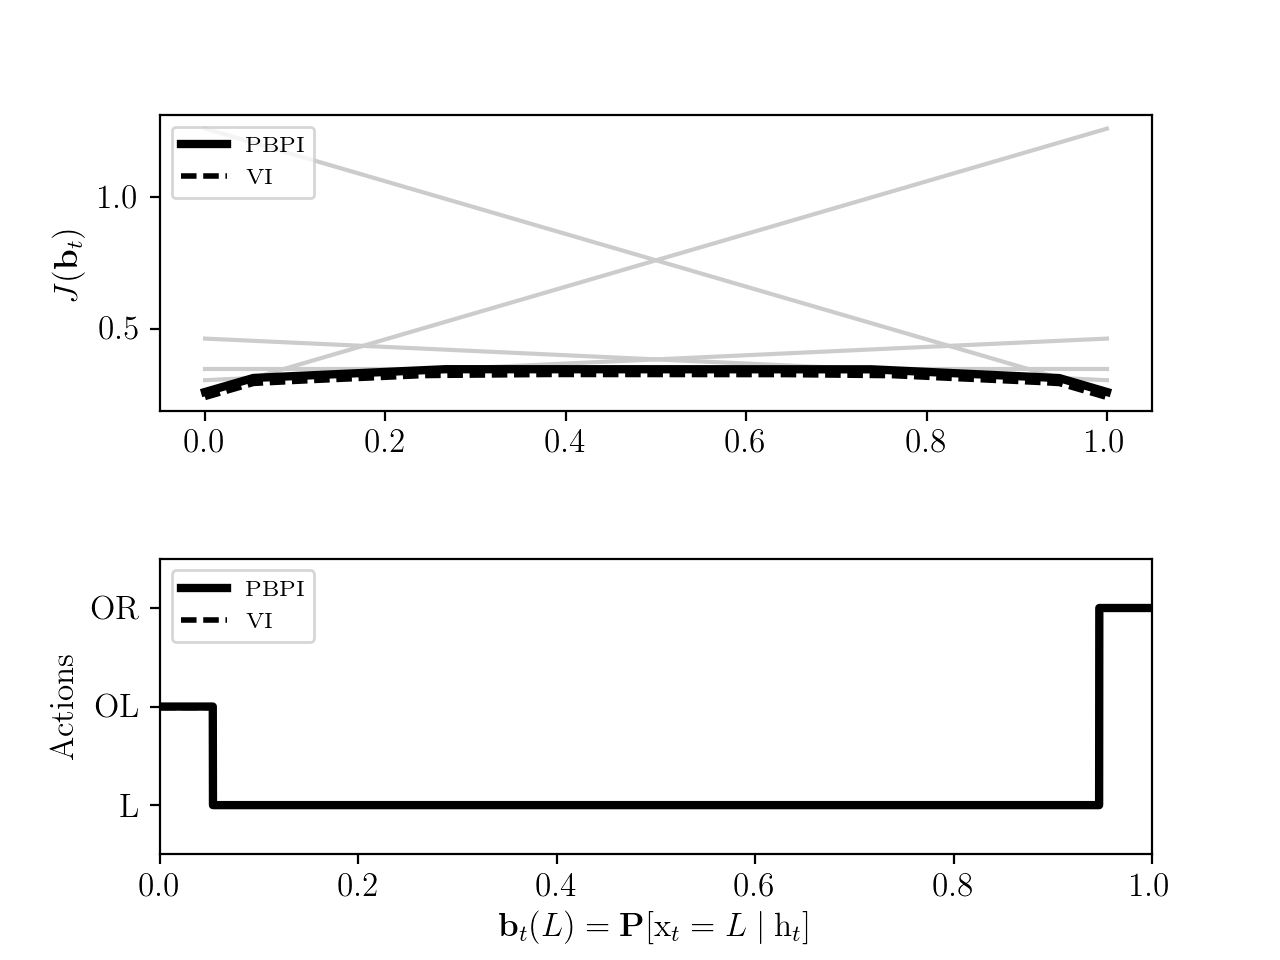

<IPython.core.display.Javascript object>


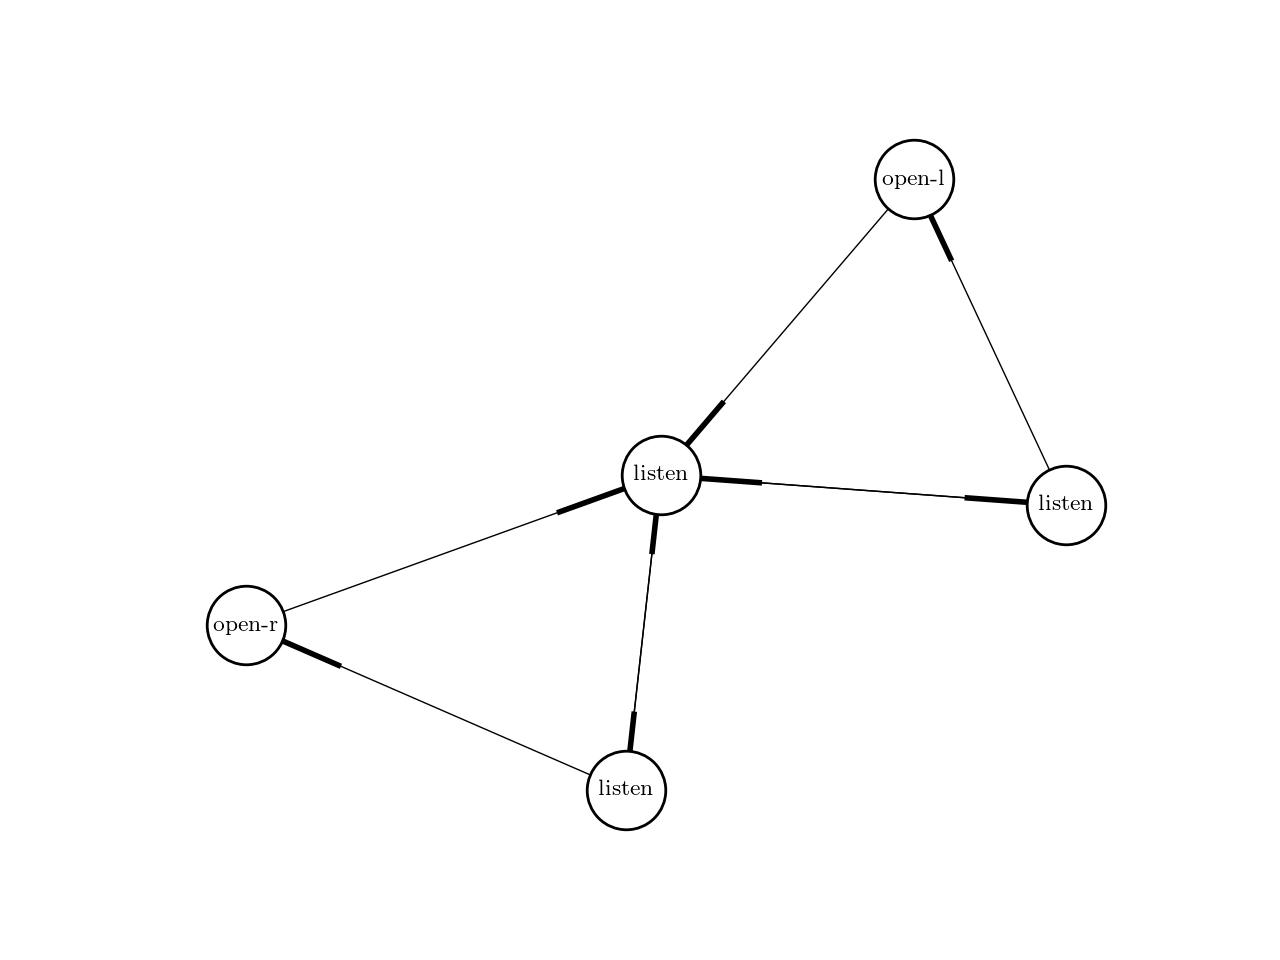

PBPI policy:
'listen' -> {4, 3}
'open-left' -> {0, 0}
'open-right' -> {0, 0}
'listen' -> {0, 1}
'listen' -> {2, 0}

Vectors for perseus:
[[ 0.46231181  0.30439148  0.25954474  1.25954474  0.34605965]
 [ 0.30439148  0.46231181  1.25954474  0.25954474  0.34605965]]
Vectors for PBPI:
[[ 0.34605965  1.25954473  0.25954473  0.46231181  0.30439148]
 [ 0.34605965  0.25954473  1.25954473  0.30439148  0.46231181]]


In [40]:
p = []
y_per = []
y_opt = []
y_pbpi = []
a_per = []
a_opt = []
a_pbpi = []

for i in range(10000):
    p = p + [i * 1/9999]
    b = np.array([p[i], 1 - p[i]])
    y_per += [b.dot(g_per).min()]
    y_pbpi += [b.dot(g_pbpi).min()]
    y_opt += [b.dot(g_opt).min()-2e-3]
    
    aux = l_per[int(b.dot(g_per).argmin())]
    a_per += [M.get_action_index(aux)]

    aux = l_opt[b.dot(g_opt).argmin()]
    a_opt += [M.get_action_index(aux)-1e-2]

    aux = l_pbpi[b.dot(g_pbpi).argmin()]
    a_pbpi += [M.get_action_index(aux)]

fig = plt.figure()

plt.subplot(211)
for v in range(g_per.shape[1]):    
    plt.plot(g_per[:, v], '-', color='0.80')
    
plt.plot(p, y_per, 'k-', linewidth=3, label=r'{\sc PERSEUS}')
plt.plot(p, y_opt, 'k--', linewidth=2, label='VI')
plt.legend(loc='upper left', fontsize='x-small')
plt.ylabel(r'$J(\mathbf{b}_t)')

plt.subplot(212)
plt.plot(p, a_per, 'k-', linewidth=3, label=r'{\sc PERSEUS}')
plt.plot(p, a_opt, 'k--', linewidth=2, label='VI')
plt.axis([0, 1, -.5, 2.5])
plt.yticks([0, 1, 2], ['L', 'OL', 'OR'])
plt.legend(loc='upper left', fontsize='x-small')
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel('Actions')

fig.subplots_adjust(hspace=.5)

plt.show()
plt.savefig('tiger-perseus.pdf')

fig = plt.figure()

plt.subplot(211)
for v in range(g_pbpi.shape[1]):    
    plt.plot(g_pbpi[:, v], '-', color='0.80')
    
plt.plot(p, y_pbpi, 'k-', linewidth=3, label=r'PBPI')
plt.plot(p, y_opt, 'k--', linewidth=2, label='VI')
plt.legend(loc='upper left', fontsize='x-small')
plt.ylabel(r'$J(\mathbf{b}_t)')

plt.subplot(212)
plt.plot(p, a_pbpi, 'k-', linewidth=3, label=r'PBPI')
plt.plot(p, a_opt, 'k--', linewidth=2, label='VI')
plt.axis([0, 1, -.5, 2.5])
plt.yticks([0, 1, 2], ['L', 'OL', 'OR'])
plt.legend(loc='upper left', fontsize='x-small')
plt.xlabel(r'$\mathbf{b}_t(L)=\mathbf{P}[\mathrm{x}_t=L\mid\mathrm{h}_t]$')
plt.ylabel('Actions')

fig.subplots_adjust(hspace=.5)

plt.show()
plt.savefig('tiger-pbpi.pdf')

sol.draw(pol_pbpi)
plt.show()
plt.savefig('tiger-pbpi-pgraph.pdf')

print('PBPI policy:')
print(pol_pbpi)

print('Vectors for perseus:')
print(g_per)
print('Vectors for PBPI:')
print(g_pbpi)

### 7-state

In [41]:
M = env.seven_states()
q_MDP, _ = sol.value_iteration(M, as_mdp=True, cost=False)
q_FIB, _ = sol.fib(M)
print("QMDP:")
print(q_MDP)
print("QFIB:")
print(q_FIB)

print('\nQ-MDP action for belief [0, 0.5, 0.5, 0, 0, 0, 0]:')
print(np.array([[0, 0.5, 0.5, 0, 0, 0, 0]]).dot(q_MDP))
print('\nFIB action for belief [0, 0.5, 0.5, 0, 0, 0, 0]:')
print(np.array([[0, 0.5, 0.5, 0, 0, 0, 0]]).dot(q_FIB))

FIB ended after 456 iterations
QMDP:
[[ 13.67221735  13.67221735  13.67221735]
 [ 13.33917616  14.28917616  13.98860648]
 [ 14.28917616  13.33917616  13.98860648]
 [ 13.67221735  13.67221735  13.67221735]
 [ 13.67221735  13.67221735  13.67221735]
 [ 12.98860648  12.98860648  12.98860648]
 [ 13.98860648  13.98860648  13.98860648]]
QFIB:
[[ 16.39948004  16.39948004  16.39948004]
 [ 15.80053073  16.75053073  16.20997899]
 [ 16.75053073  15.80053073  16.20997899]
 [ 16.0105042   16.0105042   16.0105042 ]
 [ 16.0105042   16.0105042   16.0105042 ]
 [ 15.57950604  15.57950604  15.57950604]
 [ 16.57950604  16.57950604  16.57950604]]

Q-MDP action for belief [0, 0.5, 0.5, 0, 0, 0, 0]:
[[ 13.81417616  13.81417616  13.98860648]]

FIB action for belief [0, 0.5, 0.5, 0, 0, 0, 0]:
[[ 16.27553073  16.27553073  16.20997899]]


### Slotted aloha

In [49]:
print('\n\n -- Slotted ALOHA example -- \n')

print('--> Loading...')

M = env.parse('domains/aloha.10.POMDP')

print('\n--> Running PERSEUS...')
t = time.time()
g_per, l_per, s_per, i_per = sol.perseus(M, successors_out=True)
t_per = time.time() - t

print('Completed in', i_per, 'iterations.')
print('Computation time:', t_per, 'seconds.')



 -- Slotted ALOHA example -- 

--> Loading...
Preamble: processed successfully.
Start: processed successfully.
Stochastic matrix T: processed successfully.
Stochastic matrix O: processed successfully.
Cost matrix: processed successfully.
File domains/aloha.10.POMDP processed successfully.

--> Running PERSEUS...
Sampling... Complete. Running...
Completed 25 iterations so far. Still running...
Completed 50 iterations so far. Still running...
Completed 75 iterations so far. Still running...
Completed 100 iterations so far. Still running...
Completed 125 iterations so far. Still running...
Completed 150 iterations so far. Still running...
Completed 175 iterations so far. Still running...
Completed 200 iterations so far. Still running...
Completed 225 iterations so far. Still running...
Completed 250 iterations so far. Still running...
Completed 275 iterations so far. Still running...
Completed 300 iterations so far. Still running...
Completed 325 iterations so far. Still running...
Comp


--> Drawing and saving policy graph...


<IPython.core.display.Javascript object>


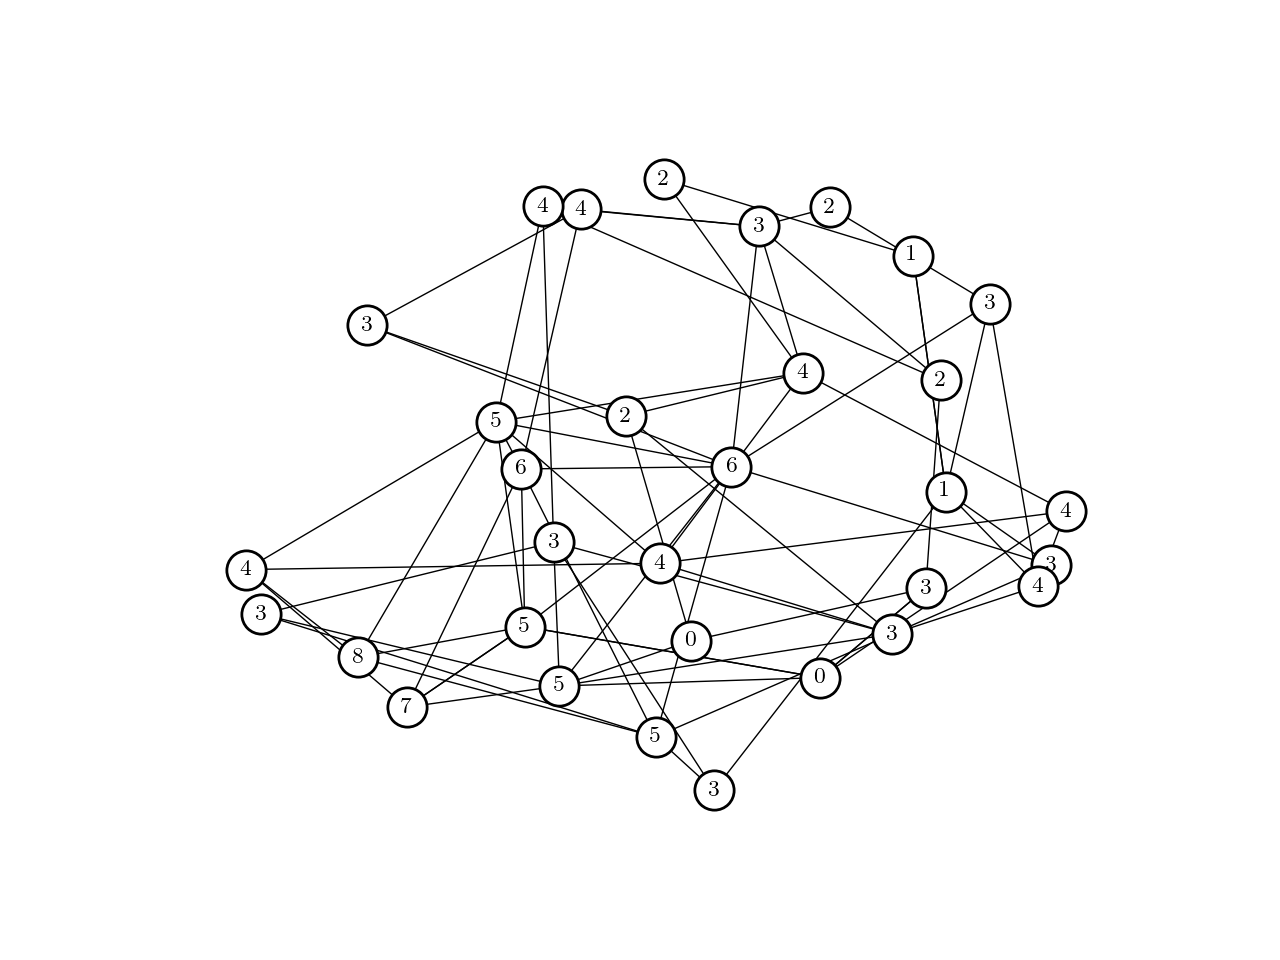

Drawing complete.
'5' -> {4, 9, 3}
'4' -> {16, 16, 4}
'8' -> {1, 0, 1}
'7' -> {0, 3, 1}
'5' -> {2, 2, 5}
'6' -> {3, 5, 0}
'6' -> {5, 4, 0}
'3' -> {13, 19, 6}
'3' -> {24, 24, 6}
'0' -> {18, 0, 0}
'4' -> {8, 8, 5}
'4' -> {15, 11, 4}
'3' -> {24, 22, 27}
'1' -> {21, 21, 14}
'4' -> {7, 12, 23}
'3' -> {10, 10, 6}
'4' -> {11, 12, 4}
'3' -> {14, 13, 6}
'3' -> {20, 20, 9}
'5' -> {6, 2, 5}
'2' -> {26, 26, 15}
'1' -> {21, 21, 13}
'5' -> {9, 6, 3}
'4' -> {11, 16, 9}
'2' -> {25, 25, 11}
'0' -> {18, 18, 22}
'4' -> {27, 15, 4}
'3' -> {22, 22, 27}
'3' -> {13, 19, 27}
'3' -> {19, 22, 27}
'2' -> {17, 17, 15}
'2' -> {21, 21, 11}


--> Saving computation statistics...Done.


In [50]:
from datetime import datetime 

pol_per = sol.extract_controller(M, g_per, l_per, s_per, g_per, l_per, s_per)

print('\n--> Drawing and saving policy graph...')

sol.draw(pol_per, 'aloha', node_size=200, arrows=False)

print('Drawing complete.')
print(pol_per)

print('\n--> Saving computation statistics...', end='')

f = open('aloha.txt', 'w')
print('-- ALOHA problem --', file=f)
print(datetime.now(), file=f)

print('\n -- SUMMARY --\n', file=f)

print('N. iterations (PERSEUS):', i_per, file=f)
print('Computation time (PERSEUS):', t_per, file=f)

f.close()

print('Done.')

<IPython.core.display.Javascript object>


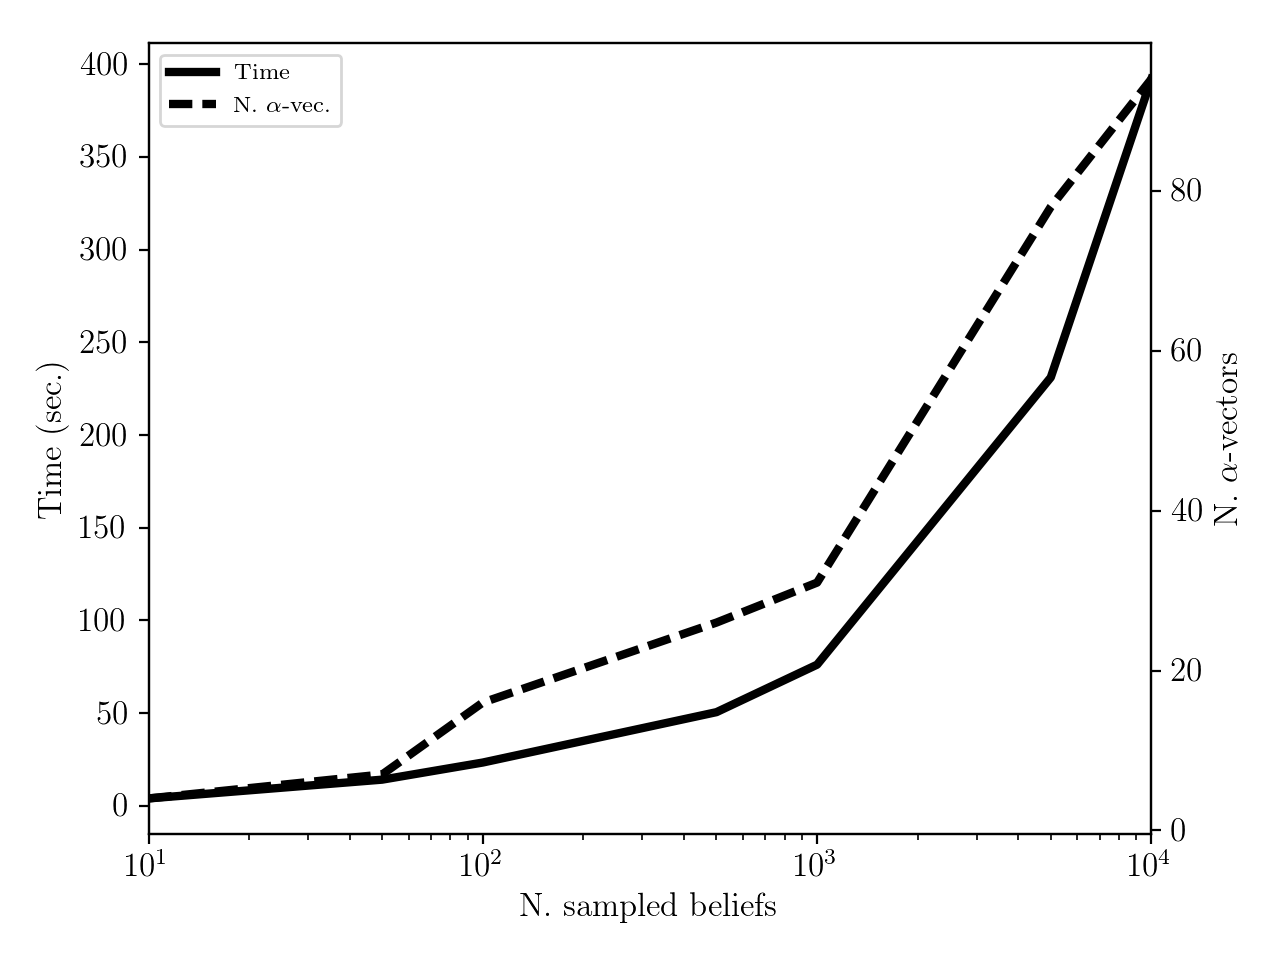

In [4]:
samples = [10, 50, 100, 500, 1000, 5000, 10000]
iterations = [1646, 3638, 4153, 5025, 5528, 6443, 6693]
time = [4.012, 14.142, 23.378, 50.547, 76.160, 231.079, 392.040]
avectors = [4, 7, 16, 26, 31, 78, 94]

fig, ax1 = plt.subplots()

plot1 = ax1.semilogx(samples, time, 'k-', linewidth=3, label='Time')
ax1.set_xlabel('N. sampled beliefs')
ax1.set_ylabel('Time (sec.)')
ax1.set_xlim(10,10000)

ax2 = ax1.twinx()
plot2 = ax2.semilogx(samples, avectors, 'k--', linewidth=3, label=r'N. $\alpha$-vec.')
ax2.set_ylabel(r'N. $\alpha$-vectors')
ax2.set_xlim(10,10000)

plots = plot1 + plot2
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc='best', fontsize='x-small')

fig.tight_layout()
plt.show()
plt.savefig('aloha-time-vectors.pdf')

### Fault detection

In [47]:
print('\n\n -- Fault detection example -- \n')

print('--> Loading...')

M = env.parse('domains/machine.POMDP')

print('\n--> Running PERSEUS...')
t = time.time()
g_per, l_per, s_per, i_per = sol.perseus(M, successors_out=True)
t_per = time.time() - t

print('Completed in', i_per, 'iterations.')
print('Computation time:', t_per, 'seconds.')



 -- Fault detection example -- 

--> Loading...
Preamble: processed successfully.
Start: processed successfully.
Stochastic matrix T: processed successfully.
Stochastic matrix O: processed successfully.
Cost matrix: processed successfully.
File domains/machine.POMDP processed successfully.

--> Running PERSEUS...
Sampling... Complete. Running...
Completed 25 iterations so far. Still running...
Completed 50 iterations so far. Still running...
Completed 75 iterations so far. Still running...
Completed 100 iterations so far. Still running...
Completed 125 iterations so far. Still running...
Completed 150 iterations so far. Still running...
Completed 175 iterations so far. Still running...
Completed 200 iterations so far. Still running...
Completed 225 iterations so far. Still running...
Completed 250 iterations so far. Still running...
Completed 275 iterations so far. Still running...
Completed 300 iterations so far. Still running...
Completed 325 iterations so far. Still running...
Com

[[ 34.59096437  34.59096437  34.77853455 ...,  34.52116835  34.96591717
   34.48632663]
 [ 34.59096437  34.59096437  34.77853455 ...,  34.52116835  34.96591717
   34.48632663]
 [ 34.59096437  34.59096437  34.77853455 ...,  34.52116835  34.96591717
   34.48632663]
 ..., 
 [ 34.02532744  34.06090029  33.95133956 ...,  33.96943062  33.98904273
   33.98872027]
 [ 33.65402705  33.66666993  33.71737109 ...,  33.70637611  33.9104099
   33.70915343]
 [ 33.45095595  33.44294604  33.67681306 ...,  33.65742148  33.90238787
   33.65765496]]

--> Drawing and saving policy graph...


<IPython.core.display.Javascript object>


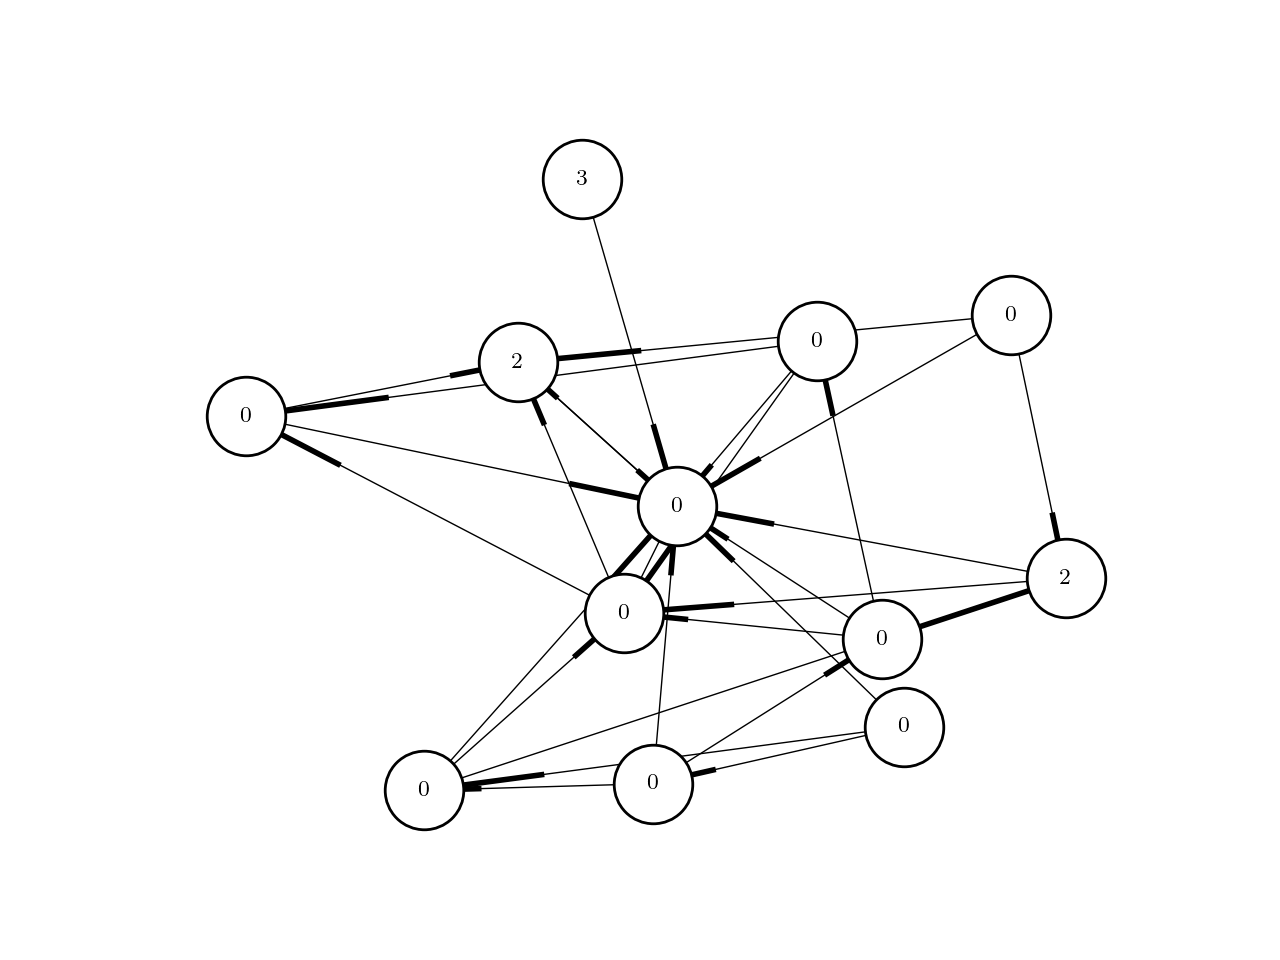

Drawing complete.
'0' -> {2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2}
'0' -> {2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
'2' -> {2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
'3' -> {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
'0' -> {1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2}
'0' -> {7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11}
'0' -> {1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4}
'0' -> {9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11}
'0' -> {10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2}
'0' -> {6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4}
'2' -> {4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
'0' -> {10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4}


--> Saving computation statistics...Done.


In [48]:
from datetime import datetime 

print(g_per)
pol_per = sol.extract_controller(M, g_per, l_per, s_per, g_per, l_per, s_per)

print('\n--> Drawing and saving policy graph...')

sol.draw(pol_per, 'machine')

print('Drawing complete.')
print(pol_per)

print('\n--> Saving computation statistics...', end='')

f = open('machine.txt', 'w')
print('-- Machine Maintenance problem --', file=f)
print(datetime.now(), file=f)

print('\n -- SUMMARY --\n', file=f)

print('N. iterations (PERSEUS):', i_per, file=f)
print('Computation time (PERSEUS):', t_per, file=f)

f.close()

print('Done.')

<IPython.core.display.Javascript object>


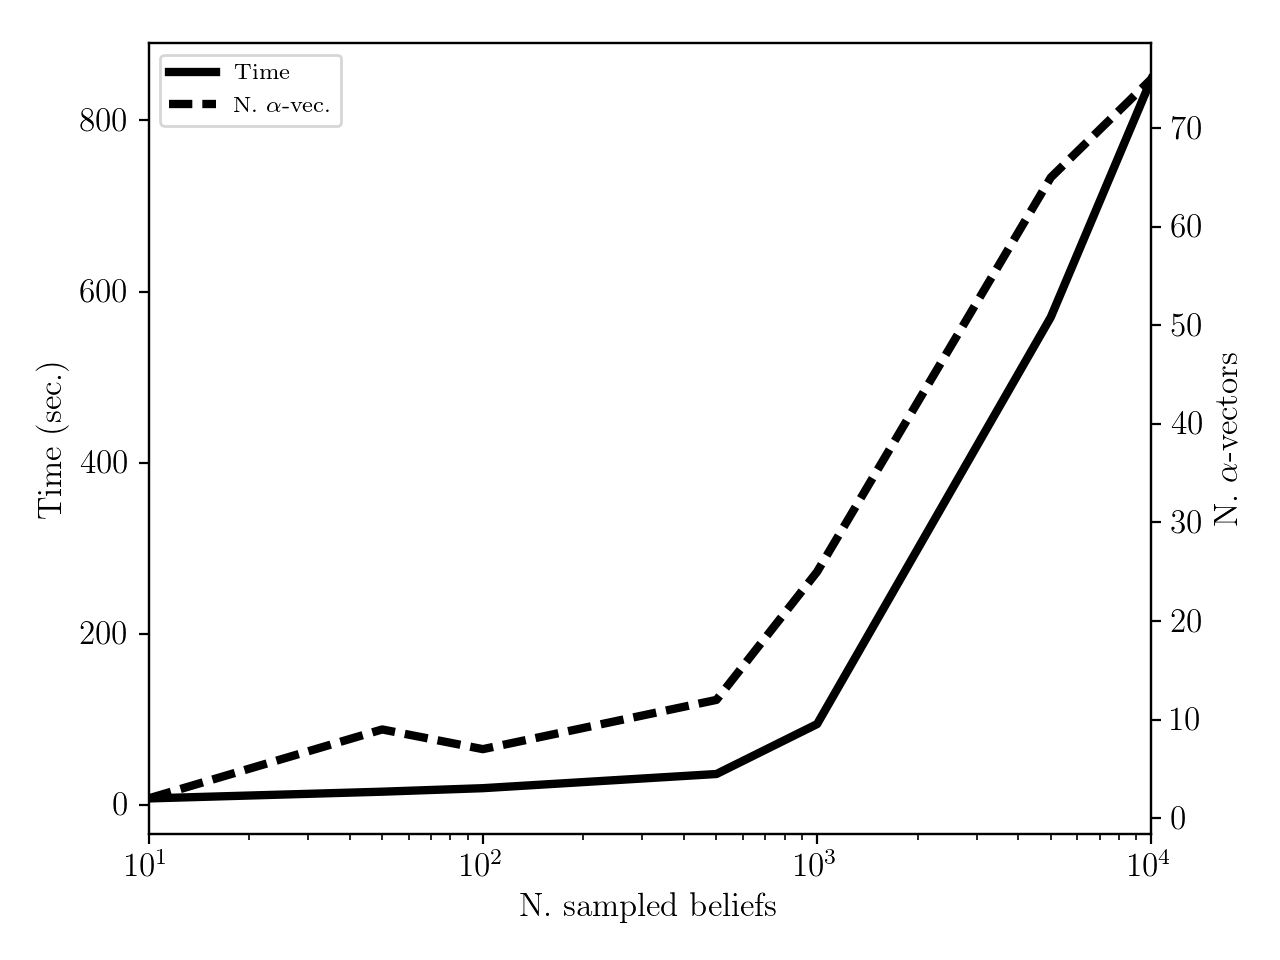

In [7]:
samples = [10, 50, 100, 500, 1000, 5000, 10000]
iterations = [3969, 5301, 5319, 7404, 8223, 9399, 9662]
time = [7.631, 15.509, 19.617, 36.177, 94.542, 570.047, 848.439]
avectors = [2, 9, 7, 12, 25, 65, 75]

fig, ax1 = plt.subplots()

plot1 = ax1.semilogx(samples, time, 'k-', linewidth=3, label='Time')
ax1.set_xlabel('N. sampled beliefs')
ax1.set_ylabel('Time (sec.)')
ax1.set_xlim(10,10000)

ax2 = ax1.twinx()
plot2 = ax2.semilogx(samples, avectors, 'k--', linewidth=3, label=r'N. $\alpha$-vec.')
ax2.set_ylabel(r'N. $\alpha$-vectors')
ax2.set_xlim(10,10000)

plots = plot1 + plot2
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc='best', fontsize='x-small')

fig.tight_layout()
plt.show()
plt.savefig('machine-time-vectors.pdf')